In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import time
import random
import math
import tensorflow as tf
from skmultiflow.drift_detection import PageHinkley, ADWIN
from skmultiflow.data import DataStream
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from tensorflow.keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from tensorflow.keras.utils import to_categorical
from scipy.stats import spearmanr
from scipy.stats import entropy
from tensorflow import keras
from sklearn import preprocessing

In [2]:
def get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
def get_initial_model_2(inp, out):
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
def DP_get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
def DP_get_initial_model_2(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
def node_comparison1(node1, node2, epsilon=0.05): #this function is to see if the nodes are atmost epsilon distance apart
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if((np.linalg.norm(np.array(x)-np.array(y))/len(x))<=epsilon):
            continue
        else:
            return False
    else:
        if(math.sqrt((x-y)*(x-y))<=epsilon):
            continue
        else:
            return False
  return True

In [7]:
def node_comparison(node1, node2):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if(sorted(x)==sorted(y)):
            continue
        else:
            return False
    else:
        if(x==y):
            continue
        else:
            return False
  return True

In [8]:
def layer_comparison(layer1, layer2): #compare same layers in two different DNNs
  for node1 in layer1:
    present=False
    for node2 in layer2:
      if (node_comparison1(node1, node2)):
        present=True
    if present==False:
      return False
  return True

In [9]:
def check_models(Model_weights1, Model_weights2): # compare two deep neural networks based on their weights
  for i in range(0,len(Model_weights1), 2):
    layer1=[]
    layer2=[]
    for j in range(len(Model_weights1[i+1].T)):
      Node1=[]
      Node2=[]
      Node1.append(list(Model_weights1[i].T[j]))
      Node1.append(Model_weights1[i+1][j])
      if (i+2<len(Model_weights1)):
        Node1.append(list(Model_weights1[i+2][j]))
      Node2.append(list(Model_weights2[i].T[j]))
      Node2.append(Model_weights2[i+1][j])
      if (i+2<len(Model_weights2)):
        Node2.append(list(Model_weights2[i+2][j]))
      layer1.append(Node1)
      layer2.append(Node2)
    if (layer_comparison(layer1, layer2)):
      continue
    else:
      return False
  return True

In [10]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    
    mean_size=len(models_weights)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [11]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_2(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_2(inp_shape, 6).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [12]:
# custom functions for f1, precision and recall

from keras import backend as K
from sklearn import preprocessing

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
# A function to check if the two samples are different:
def return_samples(Positive, Negative, data, N):
    datasets=[]
    positiveN=int((Positive.shape[0]/data.shape[0])*N)
    negativeN=int(N-positiveN)
    print(negativeN)
    while (Positive.empty==False and Negative.empty==False):
        df1=Positive.sample(min(positiveN, len(Positive)))
        Positive.drop(df1.index, inplace=True)
        """
        drop_df1=np.random.choice(df1.index,(int)(min(positiveN, math.ceil(len(Positive))/2)), replace=False)
        if len(Positive)<positiveN:
            Positive.drop(df1.index, inplace=True)
        else:
            Positive.drop(drop_df1, inplace=True)
        #print(len(Positive))
        """
        df2=Negative.sample(min(negativeN, len(Negative)))
        Negative.drop(df2.index, inplace=True)
        """
        drop_df2 = np.random.choice(df2.index,(int)(min(negativeN, math.ceil(len(Negative))/2)))
        if len(Negative)<negativeN:
            Negative.drop(df2.index, inplace = True)
        else:
            Negative.drop(drop_df2, inplace=True)
        """
        dataset=df1.append(df2, ignore_index=True)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        datasets.append(dataset)
    print("returned datasets")
    return datasets

In [14]:
#generate sampele which are plausible deniable
#there exists a data lets say data
def generate_samples(data, num_samples, N):
    samples=[]
    intersection=[]
    while num_samples>0:    
        Positive = data[data[target_variable]==0]
        Negative = data[data[target_variable]==1]
        positiveN=int((Positive.shape[0]/data.shape[0])*N)
        negativeN=int(N-positiveN)
        df1=Positive.sample(min(positiveN, len(Positive)))
        #Positive.drop(df1.index, inplace=True)
        df2=Negative.sample(min(negativeN, len(Negative)))
        #Negative.drop(df2.index, inplace=True)
        sample=df1.append(df2, ignore_index=False)
        samples.append(sample)
        num_samples-=1

    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = random.randint(0, len(samples)-1)
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [15]:
#generate sampele which are plausible deniable multiclass
#there exists a data lets say data
def generate_samples_multi(data, num_samples, N):
    samples=[]
    intersection=[]
    labels = [0,1,2,3,4,5]
    len_clas=[]
    data_cls=[]
    target_variable='Class'
    #print(data)
    
    for i in range(len(labels)):
        data_cls.append(data[data[target_variable]==labels[i]])
        len_clas.append(int(((data_cls[i].shape[0]*data.shape[0])/data[data[target_variable]==labels[i]].shape[0])))
    #print(data_cls)
    #print(len_clas)
    while num_samples>0:  
        for i in range(len(labels)):
            if i==0:
                df=data_cls[i].sample(min(len(data_cls[i]), len_clas[i]))
            else:
                df1=data_cls[i].sample(min(len(data_cls[i]), len_clas[i]))
                df=df.append(df1, ignore_index = True)
        df=df.sample(frac=1)
        df=df.sample(frac=1)
        df=df.sample(frac=1)
        samples.append(df)
        num_samples-=1
    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = 0 #here intentionally done 0 fas poker has enough number of 0 class
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [16]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights(add_weights[i],data.shape[1]-1, 6))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable], num_classes=6)
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model(X_test.shape[1], 6)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [17]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation_2(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights_2(add_weights[i],data.shape[1]-1, 6))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable], num_classes=6)
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model_2(X_test.shape[1], 6)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [18]:
def drift_detection(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable], num_classes=6)
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model(incoming_data.shape[1]-1, 6)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [19]:
def drift_detection_2(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable], num_classes=6)
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model_2(incoming_data.shape[1]-1, 6)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [20]:
def update_train_data(train_data, incoming_data):
    train_data.drop(index=train_data.index[:len(incoming_data)], inplace=True)
    train_data=train_data.append(incoming_data, ignore_index=True)
    return train_data

In [21]:
dataset = pd.read_csv("./artificial/insects/INSECTS-abrupt_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

2
some intersection
finished


In [39]:
# adding dense layer
# adding dense layer
initial_model= get_initial_model_2(dataset.shape[1]-1, 6)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]
true_values=[]
while ind<len(samples):
  
  train_data=samples[ind]
  ind=ind+1
  
  
  ann_model=get_initial_model_2(dataset.shape[1]-1, 6) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  

  y_train=to_categorical(train_data[target_variable], num_classes = 6)
    
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy') # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
  print(history.history['accuracy'][-1])

  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      add_weights[i].append(ann_model.get_weights())
      break;
  if present==False:
    add_weights.append([ann_model.get_weights()])
    Models.append([ann_model.get_weights(), 1])
    

len(Models)   
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])
#add_weights=add_weights[A]

# Now trying to generate Streaming settings for the dataset
# lets find the outputs from all the 
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

y_pred_total = []
y_pred_uncertainty_total = []

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init.copy()[target_variable])



Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7519 - accuracy: 0.2907 - val_loss: 1.6691 - val_accuracy: 0.3113
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5034 - accuracy: 0.4585 - val_loss: 1.3149 - val_accuracy: 0.5109
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1243 - accuracy: 0.5907 - val_loss: 1.0218 - val_accuracy: 0.5922
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9263 - accuracy: 0.6667 - val_loss: 0.9212 - val_accuracy: 0.6537
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8585 - accuracy: 0.6927 - val_loss: 0.8846 - val_accuracy: 0.6708
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8230 - accuracy: 0.6991 - val_loss: 0.8633 - val_accuracy: 0.6783
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8001 - accuracy: 0.7036 - val_loss: 0.8474 - val_accuracy: 0.6755
Epoch 

Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8201 - accuracy: 0.7055 - val_loss: 0.7901 - val_accuracy: 0.7152
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8001 - accuracy: 0.7109 - val_loss: 0.7784 - val_accuracy: 0.7029
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7856 - accuracy: 0.7168 - val_loss: 0.7625 - val_accuracy: 0.7171
0.7168204188346863
Epoch 1/10
133/133 [==============================] - 2s 2ms/step - loss: 1.7494 - accuracy: 0.3031 - val_loss: 1.6611 - val_accuracy: 0.4087
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4980 - accuracy: 0.4668 - val_loss: 1.2920 - val_accuracy: 0.4891
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1551 - accuracy: 0.5803 - val_loss: 0.9997 - val_accuracy: 0.6462
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9734 - accuracy: 0.6430 - val_loss: 0.9026 - val_acc

Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9130 - accuracy: 0.6652 - val_loss: 0.8761 - val_accuracy: 0.6793
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8843 - accuracy: 0.6723 - val_loss: 0.8579 - val_accuracy: 0.6887
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8619 - accuracy: 0.6804 - val_loss: 0.8460 - val_accuracy: 0.6916
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8448 - accuracy: 0.6868 - val_loss: 0.8268 - val_accuracy: 0.7077
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8268 - accuracy: 0.6969 - val_loss: 0.8147 - val_accuracy: 0.7143
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8118 - accuracy: 0.7007 - val_loss: 0.7953 - val_accuracy: 0.7200
0.7007333636283875
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7466 - accuracy: 0.2806 - val_loss: 1.6463 - val_acc

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4688 - accuracy: 0.4881 - val_loss: 1.2376 - val_accuracy: 0.5478
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0898 - accuracy: 0.6158 - val_loss: 0.9980 - val_accuracy: 0.6518
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9351 - accuracy: 0.6638 - val_loss: 0.8876 - val_accuracy: 0.6906
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8637 - accuracy: 0.6828 - val_loss: 0.8392 - val_accuracy: 0.7048
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8188 - accuracy: 0.6951 - val_loss: 0.7980 - val_accuracy: 0.7152
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7843 - accuracy: 0.7119 - val_loss: 0.7694 - val_accuracy: 0.7360
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7587 - accuracy: 0.7166 - val_loss: 0.7464 - val_accuracy: 0.7465
Epoch 

133/133 [==============================] - 0s 1ms/step - loss: 0.7614 - accuracy: 0.7161 - val_loss: 0.7724 - val_accuracy: 0.7171
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7444 - accuracy: 0.7206 - val_loss: 0.7606 - val_accuracy: 0.7209
0.7206056118011475
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7533 - accuracy: 0.2259 - val_loss: 1.6623 - val_accuracy: 0.2214
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5002 - accuracy: 0.3445 - val_loss: 1.3085 - val_accuracy: 0.4797
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1460 - accuracy: 0.5571 - val_loss: 1.0613 - val_accuracy: 0.6168
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9783 - accuracy: 0.6485 - val_loss: 0.9524 - val_accuracy: 0.6632
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8757 - accuracy: 0.6915 - val_loss: 0.8785 - val_accuracy: 0.67

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8233 - accuracy: 0.6958 - val_loss: 0.8464 - val_accuracy: 0.6973
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7998 - accuracy: 0.7050 - val_loss: 0.8284 - val_accuracy: 0.7029
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7832 - accuracy: 0.7076 - val_loss: 0.8163 - val_accuracy: 0.7124
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7672 - accuracy: 0.7137 - val_loss: 0.8014 - val_accuracy: 0.7152
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7541 - accuracy: 0.7187 - val_loss: 0.7905 - val_accuracy: 0.7105
0.7187130451202393
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7509 - accuracy: 0.3099 - val_loss: 1.6596 - val_accuracy: 0.4484
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4560 - accuracy: 0.4807 - val_loss: 1.2409 - val_acc

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1077 - accuracy: 0.5917 - val_loss: 1.0342 - val_accuracy: 0.6216
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9416 - accuracy: 0.6577 - val_loss: 0.9357 - val_accuracy: 0.6395
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8742 - accuracy: 0.6837 - val_loss: 0.8969 - val_accuracy: 0.6329
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8336 - accuracy: 0.6910 - val_loss: 0.8506 - val_accuracy: 0.6831
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8071 - accuracy: 0.7036 - val_loss: 0.8330 - val_accuracy: 0.6973
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7863 - accuracy: 0.7142 - val_loss: 0.8097 - val_accuracy: 0.6859
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7739 - accuracy: 0.7123 - val_loss: 0.8080 - val_accuracy: 0.6802
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7160 - accuracy: 0.7391 - val_loss: 0.7522 - val_accuracy: 0.7124
0.7390584349632263
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7507 - accuracy: 0.1982 - val_loss: 1.6722 - val_accuracy: 0.2990
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5135 - accuracy: 0.4493 - val_loss: 1.3494 - val_accuracy: 0.5506
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1734 - accuracy: 0.5744 - val_loss: 1.0411 - val_accuracy: 0.6168
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9733 - accuracy: 0.6470 - val_loss: 0.9347 - val_accuracy: 0.6528
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9099 - accuracy: 0.6641 - val_loss: 0.8976 - val_accuracy: 0.6698
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8790 - accuracy: 0.6842 - val_loss: 0.8717 - val_acc

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8416 - accuracy: 0.6875 - val_loss: 0.8381 - val_accuracy: 0.7133
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8170 - accuracy: 0.7024 - val_loss: 0.8225 - val_accuracy: 0.7152
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8007 - accuracy: 0.7024 - val_loss: 0.7945 - val_accuracy: 0.7304
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7824 - accuracy: 0.7130 - val_loss: 0.7855 - val_accuracy: 0.7275
0.7130352258682251
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7521 - accuracy: 0.2721 - val_loss: 1.6595 - val_accuracy: 0.4201
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4600 - accuracy: 0.4935 - val_loss: 1.1942 - val_accuracy: 0.5885
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0662 - accuracy: 0.6212 - val_loss: 0.9368 - val_acc

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
166/166 [==============================] - 0s 549us/step


In [40]:
print(len(A))

5


In [41]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]
        
        samples = generate_samples_multi(data_init.copy(), 50, N)
        
        while ind<len(samples):
            
            train_data=samples[ind]
            ind+=1
            
            ann_model = get_initial_model_2(dataset.shape[1]-1, 6) #same intial weights
            ann_model.set_weights(initial_model.get_weights())
            X_train=train_data.drop(columns=[target_variable])
            print(X_train.shape[1])

            y_train=to_categorical(train_data[target_variable], num_classes = 6)

            ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
            history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
            print(history.history['accuracy'][-1])



            present=False
            for i in range(len(Models)):
                if (check_models(Models[i][0], ann_model.get_weights())):
                  print("if any")
                  Models[i][1]=Models[i][1]+1
                  add_weights[i].append(ann_model.get_weights())
                
                  present=True
                  break;
            if present==False:
                add_weights.append([ann_model.get_weights()])
                Models.append([ann_model.get_weights(), 1])
                
        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))



# this is for classification




33/33 [==============================] - 0s 615us/step
1056
One lap done.
33/33 [==============================] - 0s 594us/step
1056
One lap done.
33/33 [==============================] - 0s 603us/step
1056
One lap done.
33/33 [==============================] - 0s 580us/step
1056
One lap done.
33/33 [==============================] - 0s 609us/step
1056
One lap done.
33/33 [==============================] - 0s 622us/step
1056
One lap done.
33/33 [==============================] - 0s 634us/step
1056
One lap done.
33/33 [==============================] - 0s 574us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7493 - accuracy: 0.2652 - val_loss: 1.6542 - val_accuracy: 0.2999
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4645 - accuracy: 0.4566 - val_loss: 1.2402 - val_accuracy: 0.5676
Epoch 3/10
133/133 [==============================] - 0s 1ms

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4765 - accuracy: 0.4793 - val_loss: 1.2402 - val_accuracy: 0.5809
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1150 - accuracy: 0.6044 - val_loss: 0.9820 - val_accuracy: 0.6708
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9511 - accuracy: 0.6532 - val_loss: 0.8786 - val_accuracy: 0.6925
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8730 - accuracy: 0.6738 - val_loss: 0.8372 - val_accuracy: 0.7219
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8315 - accuracy: 0.6915 - val_loss: 0.7956 - val_accuracy: 0.7237
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8028 - accuracy: 0.7055 - val_loss: 0.7695 - val_accuracy: 0.7275
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7817 - accuracy: 0.7026 - val_loss: 0.7673 - val_accuracy: 0.7342
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7793 - accuracy: 0.7107 - val_loss: 0.7520 - val_accuracy: 0.7304
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7697 - accuracy: 0.7062 - val_loss: 0.7437 - val_accuracy: 0.7351
0.7061746120452881
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7515 - accuracy: 0.2858 - val_loss: 1.6616 - val_accuracy: 0.4078
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4886 - accuracy: 0.4715 - val_loss: 1.2747 - val_accuracy: 0.5147
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1213 - accuracy: 0.5874 - val_loss: 1.0038 - val_accuracy: 0.6254
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9553 - accuracy: 0.6551 - val_loss: 0.9002 - val_accuracy: 0.6746
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8844 - accuracy: 0.6792 - val_loss: 0.8448 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8633 - accuracy: 0.6790 - val_loss: 0.8716 - val_accuracy: 0.6954
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8418 - accuracy: 0.6899 - val_loss: 0.8475 - val_accuracy: 0.7096
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8191 - accuracy: 0.7019 - val_loss: 0.8230 - val_accuracy: 0.7247
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8012 - accuracy: 0.7078 - val_loss: 0.8067 - val_accuracy: 0.7190
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7834 - accuracy: 0.7142 - val_loss: 0.7867 - val_accuracy: 0.7417
0.7142181396484375
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7467 - accuracy: 0.3284 - val_loss: 1.6539 - val_accuracy: 0.4295
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4762 - accuracy: 0.4668 - val_loss: 1.2767 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1390 - accuracy: 0.5515 - val_loss: 1.0841 - val_accuracy: 0.6197
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0242 - accuracy: 0.6291 - val_loss: 1.0097 - val_accuracy: 0.6272
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9638 - accuracy: 0.6619 - val_loss: 0.9543 - val_accuracy: 0.6689
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9123 - accuracy: 0.6804 - val_loss: 0.9137 - val_accuracy: 0.6802
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8725 - accuracy: 0.6977 - val_loss: 0.8853 - val_accuracy: 0.6935
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8382 - accuracy: 0.7111 - val_loss: 0.8464 - val_accuracy: 0.7096
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8121 - accuracy: 0.7194 - val_loss: 0.8259 - val_accuracy: 0.7029
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7862 - accuracy: 0.7130 - val_loss: 0.7387 - val_accuracy: 0.7389
0.7130352258682251
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7435 - accuracy: 0.2633 - val_loss: 1.6377 - val_accuracy: 0.3765
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4187 - accuracy: 0.4895 - val_loss: 1.1746 - val_accuracy: 0.5695
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0587 - accuracy: 0.6089 - val_loss: 0.9808 - val_accuracy: 0.6424
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9300 - accuracy: 0.6598 - val_loss: 0.9137 - val_accuracy: 0.6632
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8805 - accuracy: 0.6740 - val_loss: 0.8904 - val_accuracy: 0.6859
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8508 - accuracy: 0.6880 - val_loss: 0.8561 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8509 - accuracy: 0.6932 - val_loss: 0.8344 - val_accuracy: 0.7190
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8278 - accuracy: 0.7003 - val_loss: 0.8313 - val_accuracy: 0.7171
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8089 - accuracy: 0.7059 - val_loss: 0.7948 - val_accuracy: 0.7398
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7901 - accuracy: 0.7159 - val_loss: 0.7819 - val_accuracy: 0.7465
0.7158741354942322
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7488 - accuracy: 0.2643 - val_loss: 1.6442 - val_accuracy: 0.3851
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4795 - accuracy: 0.4710 - val_loss: 1.2560 - val_accuracy: 0.5393
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0962 - accuracy: 0.5931 - val_loss: 0.9575 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9370 - accuracy: 0.6570 - val_loss: 0.9468 - val_accuracy: 0.6556
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8652 - accuracy: 0.6861 - val_loss: 0.8883 - val_accuracy: 0.6708
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8209 - accuracy: 0.7022 - val_loss: 0.8571 - val_accuracy: 0.6783
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7949 - accuracy: 0.7083 - val_loss: 0.8263 - val_accuracy: 0.6887
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7732 - accuracy: 0.7147 - val_loss: 0.8023 - val_accuracy: 0.6991
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7568 - accuracy: 0.7230 - val_loss: 0.7843 - val_accuracy: 0.7058
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7434 - accuracy: 0.7230 - val_loss: 0.7737 - val_accuracy: 0.7077
0.722

0.7198958992958069
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7420 - accuracy: 0.3220 - val_loss: 1.6136 - val_accuracy: 0.3964
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4138 - accuracy: 0.4942 - val_loss: 1.1766 - val_accuracy: 0.5563
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0584 - accuracy: 0.6203 - val_loss: 0.9588 - val_accuracy: 0.6481
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9144 - accuracy: 0.6674 - val_loss: 0.9001 - val_accuracy: 0.6717
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8623 - accuracy: 0.6856 - val_loss: 0.8588 - val_accuracy: 0.6764
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8234 - accuracy: 0.6977 - val_loss: 0.8419 - val_accuracy: 0.7029
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7939 - accuracy: 0.7133 - val_loss: 0.8094 - val_a

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 589us/step
one thing
33/33 [==============================] - 0s 624us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7470 - accuracy: 0.3343 - val_loss: 1.6595 - val_accuracy: 0.3813
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4647 - accuracy: 0.4630 - val_loss: 1.2816 - val_accuracy: 0.5383
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0961 - accuracy: 0.6234 - val_loss: 1.0129 - val_accuracy: 0.6339
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9164 - accuracy: 0.6726 - val_loss: 0.9267 - val_accuracy: 0.6802
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8485 - accuracy: 0.6986 - val_loss: 0.8882 - val_accuracy: 0.6727
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

133/133 [==============================] - 0s 1ms/step - loss: 0.8418 - accuracy: 0.7078 - val_loss: 0.8162 - val_accuracy: 0.7058
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7990 - accuracy: 0.7142 - val_loss: 0.7853 - val_accuracy: 0.7086
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7701 - accuracy: 0.7216 - val_loss: 0.7649 - val_accuracy: 0.7228
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7480 - accuracy: 0.7237 - val_loss: 0.7467 - val_accuracy: 0.7247
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7342 - accuracy: 0.7282 - val_loss: 0.7332 - val_accuracy: 0.7304
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7228 - accuracy: 0.7331 - val_loss: 0.7250 - val_accuracy: 0.7266
0.7331440448760986
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7425 - accuracy: 0.2475 - val_loss: 1.6068 - val_accuracy: 0

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4280 - accuracy: 0.5060 - val_loss: 1.1889 - val_accuracy: 0.5402
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0617 - accuracy: 0.5997 - val_loss: 0.9902 - val_accuracy: 0.6433
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9421 - accuracy: 0.6503 - val_loss: 0.9330 - val_accuracy: 0.6604
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8925 - accuracy: 0.6683 - val_loss: 0.8993 - val_accuracy: 0.6547
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8620 - accuracy: 0.6846 - val_loss: 0.8665 - val_accuracy: 0.6850
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8351 - accuracy: 0.6996 - val_loss: 0.8474 - val_accuracy: 0.7001
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8140 - accuracy: 0.7045 - val_loss: 0.8224 - val_accuracy: 0.7077
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7436 - accuracy: 0.7194 - val_loss: 0.7718 - val_accuracy: 0.7124
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7282 - accuracy: 0.7256 - val_loss: 0.7532 - val_accuracy: 0.7266
0.725573718547821
33
Epoch 1/10
133/133 [==============================] - 2s 3ms/step - loss: 1.7459 - accuracy: 0.3000 - val_loss: 1.6426 - val_accuracy: 0.3841
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4220 - accuracy: 0.5025 - val_loss: 1.1795 - val_accuracy: 0.5658
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0675 - accuracy: 0.6028 - val_loss: 0.9527 - val_accuracy: 0.6632
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9464 - accuracy: 0.6466 - val_loss: 0.8937 - val_accuracy: 0.6821
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9084 - accuracy: 0.6598 - val_loss: 0.8607 - val_a

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8617 - accuracy: 0.6967 - val_loss: 0.8552 - val_accuracy: 0.6812
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8379 - accuracy: 0.7093 - val_loss: 0.8404 - val_accuracy: 0.6897
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8193 - accuracy: 0.7114 - val_loss: 0.8219 - val_accuracy: 0.6916
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8009 - accuracy: 0.7161 - val_loss: 0.8032 - val_accuracy: 0.6935
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7827 - accuracy: 0.7242 - val_loss: 0.7855 - val_accuracy: 0.7010
0.7241542339324951
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7507 - accuracy: 0.2673 - val_loss: 1.6677 - val_accuracy: 0.3699
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4808 - accuracy: 0.4729 - val_loss: 1.2612 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1258 - accuracy: 0.5680 - val_loss: 1.0344 - val_accuracy: 0.6112
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9649 - accuracy: 0.6563 - val_loss: 0.9370 - val_accuracy: 0.6500
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8820 - accuracy: 0.6811 - val_loss: 0.8746 - val_accuracy: 0.6812
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8337 - accuracy: 0.6936 - val_loss: 0.8619 - val_accuracy: 0.6802
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8041 - accuracy: 0.7069 - val_loss: 0.8192 - val_accuracy: 0.6935
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7815 - accuracy: 0.7093 - val_loss: 0.8023 - val_accuracy: 0.6925
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7656 - accuracy: 0.7142 - val_loss: 0.7966 - val_accuracy: 0.6954
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7878 - accuracy: 0.7206 - val_loss: 0.7909 - val_accuracy: 0.7067
0.7206056118011475
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7473 - accuracy: 0.2839 - val_loss: 1.6565 - val_accuracy: 0.3207
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4435 - accuracy: 0.4897 - val_loss: 1.2091 - val_accuracy: 0.5828
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0429 - accuracy: 0.6397 - val_loss: 0.9413 - val_accuracy: 0.6954
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8872 - accuracy: 0.6884 - val_loss: 0.8648 - val_accuracy: 0.7001
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8258 - accuracy: 0.7024 - val_loss: 0.8233 - val_accuracy: 0.7086
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7862 - accuracy: 0.7208 - val_loss: 0.7784 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8098 - accuracy: 0.7111 - val_loss: 0.8116 - val_accuracy: 0.6906
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7905 - accuracy: 0.7093 - val_loss: 0.8008 - val_accuracy: 0.6916
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7771 - accuracy: 0.7156 - val_loss: 0.7755 - val_accuracy: 0.7039
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7633 - accuracy: 0.7244 - val_loss: 0.7747 - val_accuracy: 0.6963
0.7243908047676086
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7474 - accuracy: 0.3128 - val_loss: 1.6570 - val_accuracy: 0.3737
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4755 - accuracy: 0.4642 - val_loss: 1.2692 - val_accuracy: 0.5553
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1049 - accuracy: 0.6028 - val_loss: 1.0015 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.6108 - val_loss: 1.0134 - val_accuracy: 0.6358
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9485 - accuracy: 0.6622 - val_loss: 0.9646 - val_accuracy: 0.6547
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8932 - accuracy: 0.6899 - val_loss: 0.9232 - val_accuracy: 0.6821
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8491 - accuracy: 0.7081 - val_loss: 0.8816 - val_accuracy: 0.7105
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8138 - accuracy: 0.7187 - val_loss: 0.8476 - val_accuracy: 0.7105
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7857 - accuracy: 0.7242 - val_loss: 0.8306 - val_accuracy: 0.7209
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7630 - accuracy: 0.7275 - val_loss: 0.8043 - val_accuracy: 0.7294
0.727

0.7348001003265381
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 603us/step
one thing
33/33 [==============================] - 0s 583us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7494 - accuracy: 0.2004 - val_loss: 1.6704 - val_accuracy: 0.2507
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5066 - accuracy: 0.3674 - val_loss: 1.3423 - val_accuracy: 0.4437
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1807 - accuracy: 0.5219 - val_loss: 1.1414 - val_accuracy: 0.5213
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0417 - accuracy: 0.5921 - val_loss: 1.0506 - val_accuracy: 0.5639
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9582 - accuracy: 0.6338 - val_loss: 0.9817 - val_accuracy: 0.5856
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4460 - accuracy: 0.4784 - val_loss: 1.2617 - val_accuracy: 0.5544
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0687 - accuracy: 0.6286 - val_loss: 1.0185 - val_accuracy: 0.6604
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8997 - accuracy: 0.6825 - val_loss: 0.9293 - val_accuracy: 0.6868
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8266 - accuracy: 0.7085 - val_loss: 0.8715 - val_accuracy: 0.6935
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7849 - accuracy: 0.7230 - val_loss: 0.8387 - val_accuracy: 0.6954
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7558 - accuracy: 0.7284 - val_loss: 0.8116 - val_accuracy: 0.6982
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7368 - accuracy: 0.7303 - val_loss: 0.8035 - val_accuracy: 0.6982
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8425 - accuracy: 0.6939 - val_loss: 0.8331 - val_accuracy: 0.6991
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8266 - accuracy: 0.7019 - val_loss: 0.8236 - val_accuracy: 0.7020
0.7019162774085999
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7531 - accuracy: 0.2983 - val_loss: 1.6594 - val_accuracy: 0.3103
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4960 - accuracy: 0.3721 - val_loss: 1.2992 - val_accuracy: 0.4465
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1762 - accuracy: 0.5250 - val_loss: 1.0461 - val_accuracy: 0.5430
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0078 - accuracy: 0.6073 - val_loss: 0.9527 - val_accuracy: 0.6623
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9324 - accuracy: 0.6515 - val_loss: 0.8849 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8355 - accuracy: 0.6953 - val_loss: 0.8640 - val_accuracy: 0.6793
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8091 - accuracy: 0.7116 - val_loss: 0.8360 - val_accuracy: 0.6925
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7884 - accuracy: 0.7145 - val_loss: 0.8165 - val_accuracy: 0.6963
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7713 - accuracy: 0.7216 - val_loss: 0.8027 - val_accuracy: 0.6991
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7569 - accuracy: 0.7213 - val_loss: 0.7944 - val_accuracy: 0.7020
0.721315324306488
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7418 - accuracy: 0.3113 - val_loss: 1.6403 - val_accuracy: 0.4059
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3716 - accuracy: 0.5155 - val_loss: 1.1728 - val_a

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1079 - accuracy: 0.6078 - val_loss: 1.0054 - val_accuracy: 0.6291
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9409 - accuracy: 0.6544 - val_loss: 0.9136 - val_accuracy: 0.6566
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8752 - accuracy: 0.6830 - val_loss: 0.8709 - val_accuracy: 0.6887
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8357 - accuracy: 0.7019 - val_loss: 0.8370 - val_accuracy: 0.7067
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8027 - accuracy: 0.7090 - val_loss: 0.8153 - val_accuracy: 0.7001
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7791 - accuracy: 0.7171 - val_loss: 0.7911 - val_accuracy: 0.7058
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7567 - accuracy: 0.7242 - val_loss: 0.7832 - val_accuracy: 0.7020
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8079 - accuracy: 0.7104 - val_loss: 0.8305 - val_accuracy: 0.6982
0.7104329466819763
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7477 - accuracy: 0.2645 - val_loss: 1.6530 - val_accuracy: 0.3888
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4381 - accuracy: 0.4902 - val_loss: 1.2480 - val_accuracy: 0.5203
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0967 - accuracy: 0.5782 - val_loss: 1.0454 - val_accuracy: 0.6272
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9659 - accuracy: 0.6421 - val_loss: 0.9443 - val_accuracy: 0.6386
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9050 - accuracy: 0.6664 - val_loss: 0.8846 - val_accuracy: 0.6878
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8622 - accuracy: 0.6865 - val_loss: 0.8448 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8122 - accuracy: 0.7085 - val_loss: 0.8038 - val_accuracy: 0.7067
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7953 - accuracy: 0.7095 - val_loss: 0.7899 - val_accuracy: 0.7105
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7762 - accuracy: 0.7135 - val_loss: 0.7850 - val_accuracy: 0.7114
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7626 - accuracy: 0.7225 - val_loss: 0.7582 - val_accuracy: 0.7058
0.7224982380867004
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7449 - accuracy: 0.3272 - val_loss: 1.6503 - val_accuracy: 0.3822
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4389 - accuracy: 0.4703 - val_loss: 1.2200 - val_accuracy: 0.5705
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0792 - accuracy: 0.6044 - val_loss: 1.0058 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9880 - accuracy: 0.6205 - val_loss: 0.9763 - val_accuracy: 0.6301
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9256 - accuracy: 0.6555 - val_loss: 0.9232 - val_accuracy: 0.6660
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8702 - accuracy: 0.6780 - val_loss: 0.8807 - val_accuracy: 0.6764
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8260 - accuracy: 0.6941 - val_loss: 0.8387 - val_accuracy: 0.6963
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7940 - accuracy: 0.7040 - val_loss: 0.8152 - val_accuracy: 0.6944
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7683 - accuracy: 0.7197 - val_loss: 0.7940 - val_accuracy: 0.7143
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7515 - accuracy: 0.7216 - val_loss: 0.7745 - val_accuracy: 0.7114
0.721

0.7061746120452881
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 624us/step
one thing
33/33 [==============================] - 0s 607us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7488 - accuracy: 0.2732 - val_loss: 1.6549 - val_accuracy: 0.4068
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4598 - accuracy: 0.4805 - val_loss: 1.2548 - val_accuracy: 0.5497
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0907 - accuracy: 0.6118 - val_loss: 1.0340 - val_accuracy: 0.6149
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9368 - accuracy: 0.6697 - val_loss: 0.9365 - val_accuracy: 0.6623
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8605 - accuracy: 0.6936 - val_loss: 0.8839 - val_accuracy: 0.6793
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

133/133 [==============================] - 0s 1ms/step - loss: 0.8930 - accuracy: 0.6655 - val_loss: 0.8936 - val_accuracy: 0.6821
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8575 - accuracy: 0.6842 - val_loss: 0.8749 - val_accuracy: 0.6850
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8331 - accuracy: 0.6951 - val_loss: 0.8507 - val_accuracy: 0.7058
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8082 - accuracy: 0.7043 - val_loss: 0.8362 - val_accuracy: 0.7058
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7918 - accuracy: 0.7100 - val_loss: 0.8268 - val_accuracy: 0.7086
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7745 - accuracy: 0.7147 - val_loss: 0.8021 - val_accuracy: 0.7247
0.7146912813186646
33
Epoch 1/10
133/133 [==============================] - 2s 2ms/step - loss: 1.7495 - accuracy: 0.2855 - val_loss: 1.6593 - val_accuracy: 0

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4926 - accuracy: 0.4275 - val_loss: 1.3156 - val_accuracy: 0.5762
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1635 - accuracy: 0.6151 - val_loss: 1.0135 - val_accuracy: 0.6377
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9563 - accuracy: 0.6560 - val_loss: 0.8908 - val_accuracy: 0.6783
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8830 - accuracy: 0.6820 - val_loss: 0.8430 - val_accuracy: 0.7077
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8468 - accuracy: 0.6910 - val_loss: 0.8112 - val_accuracy: 0.7096
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8151 - accuracy: 0.7066 - val_loss: 0.7868 - val_accuracy: 0.7209
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7930 - accuracy: 0.7109 - val_loss: 0.7683 - val_accuracy: 0.7181
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7914 - accuracy: 0.7095 - val_loss: 0.7809 - val_accuracy: 0.7190
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7752 - accuracy: 0.7171 - val_loss: 0.7660 - val_accuracy: 0.7181
0.7170569896697998
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7502 - accuracy: 0.3097 - val_loss: 1.6729 - val_accuracy: 0.3690
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5101 - accuracy: 0.4582 - val_loss: 1.3476 - val_accuracy: 0.5336
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1611 - accuracy: 0.5995 - val_loss: 1.0480 - val_accuracy: 0.6244
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9527 - accuracy: 0.6705 - val_loss: 0.9240 - val_accuracy: 0.6604
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8747 - accuracy: 0.6870 - val_loss: 0.8796 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8117 - accuracy: 0.7010 - val_loss: 0.8128 - val_accuracy: 0.7181
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7843 - accuracy: 0.7161 - val_loss: 0.7934 - val_accuracy: 0.7294
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7610 - accuracy: 0.7178 - val_loss: 0.7656 - val_accuracy: 0.7285
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7437 - accuracy: 0.7244 - val_loss: 0.7480 - val_accuracy: 0.7342
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7254 - accuracy: 0.7317 - val_loss: 0.7419 - val_accuracy: 0.7342
0.7317246198654175
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7494 - accuracy: 0.3156 - val_loss: 1.6597 - val_accuracy: 0.3623
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4827 - accuracy: 0.4547 - val_loss: 1.2925 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1728 - accuracy: 0.5299 - val_loss: 1.0568 - val_accuracy: 0.6272
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0254 - accuracy: 0.6108 - val_loss: 0.9532 - val_accuracy: 0.6632
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9352 - accuracy: 0.6574 - val_loss: 0.8679 - val_accuracy: 0.6963
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8670 - accuracy: 0.6920 - val_loss: 0.8127 - val_accuracy: 0.7058
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8180 - accuracy: 0.7085 - val_loss: 0.7634 - val_accuracy: 0.7219
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7827 - accuracy: 0.7152 - val_loss: 0.7390 - val_accuracy: 0.7200
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7571 - accuracy: 0.7237 - val_loss: 0.7151 - val_accuracy: 0.7285
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7519 - accuracy: 0.7137 - val_loss: 0.7674 - val_accuracy: 0.7275
0.7137449979782104
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7518 - accuracy: 0.2799 - val_loss: 1.6566 - val_accuracy: 0.3661
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4750 - accuracy: 0.3835 - val_loss: 1.2359 - val_accuracy: 0.5090
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1859 - accuracy: 0.5039 - val_loss: 1.0997 - val_accuracy: 0.5752
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0705 - accuracy: 0.5555 - val_loss: 0.9954 - val_accuracy: 0.5695
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9831 - accuracy: 0.6101 - val_loss: 0.9400 - val_accuracy: 0.6187
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9333 - accuracy: 0.6570 - val_loss: 0.8984 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8593 - accuracy: 0.6901 - val_loss: 0.8089 - val_accuracy: 0.7048
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8388 - accuracy: 0.6981 - val_loss: 0.7947 - val_accuracy: 0.6982
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8213 - accuracy: 0.7017 - val_loss: 0.7884 - val_accuracy: 0.7058
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8030 - accuracy: 0.7133 - val_loss: 0.7681 - val_accuracy: 0.7200
0.7132717967033386
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7444 - accuracy: 0.3120 - val_loss: 1.6490 - val_accuracy: 0.3548
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4410 - accuracy: 0.4679 - val_loss: 1.1990 - val_accuracy: 0.5752
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0684 - accuracy: 0.6291 - val_loss: 0.9694 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9430 - accuracy: 0.6719 - val_loss: 0.8972 - val_accuracy: 0.6793
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8643 - accuracy: 0.6967 - val_loss: 0.8332 - val_accuracy: 0.7058
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8235 - accuracy: 0.7066 - val_loss: 0.8047 - val_accuracy: 0.7143
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7930 - accuracy: 0.7182 - val_loss: 0.7806 - val_accuracy: 0.7219
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7681 - accuracy: 0.7197 - val_loss: 0.7639 - val_accuracy: 0.7247
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7503 - accuracy: 0.7220 - val_loss: 0.7458 - val_accuracy: 0.7332
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7321 - accuracy: 0.7301 - val_loss: 0.7329 - val_accuracy: 0.7266
0.730

0.7258102893829346
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 614us/step
one thing
33/33 [==============================] - 0s 629us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7553 - accuracy: 0.3835 - val_loss: 1.6669 - val_accuracy: 0.4711
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5317 - accuracy: 0.4649 - val_loss: 1.3193 - val_accuracy: 0.5052
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2050 - accuracy: 0.5351 - val_loss: 1.0475 - val_accuracy: 0.6149
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0212 - accuracy: 0.6302 - val_loss: 0.9228 - val_accuracy: 0.6840
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9261 - accuracy: 0.6629 - val_loss: 0.8500 - val_accuracy: 0.6831
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4328 - accuracy: 0.4812 - val_loss: 1.1963 - val_accuracy: 0.5478
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0734 - accuracy: 0.6099 - val_loss: 0.9534 - val_accuracy: 0.6216
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9394 - accuracy: 0.6541 - val_loss: 0.8689 - val_accuracy: 0.6717
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8874 - accuracy: 0.6738 - val_loss: 0.8309 - val_accuracy: 0.6802
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8497 - accuracy: 0.6872 - val_loss: 0.8153 - val_accuracy: 0.6717
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8202 - accuracy: 0.7005 - val_loss: 0.7690 - val_accuracy: 0.7209
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7986 - accuracy: 0.7107 - val_loss: 0.7508 - val_accuracy: 0.7247
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7640 - accuracy: 0.7201 - val_loss: 0.8148 - val_accuracy: 0.6887
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7482 - accuracy: 0.7268 - val_loss: 0.8057 - val_accuracy: 0.6906
0.7267565727233887
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7476 - accuracy: 0.3317 - val_loss: 1.6361 - val_accuracy: 0.4361
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4633 - accuracy: 0.4611 - val_loss: 1.2410 - val_accuracy: 0.5885
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1190 - accuracy: 0.6049 - val_loss: 0.9825 - val_accuracy: 0.6613
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9685 - accuracy: 0.6558 - val_loss: 0.8917 - val_accuracy: 0.6944
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8971 - accuracy: 0.6738 - val_loss: 0.8232 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8444 - accuracy: 0.6988 - val_loss: 0.8255 - val_accuracy: 0.7020
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8222 - accuracy: 0.7076 - val_loss: 0.7983 - val_accuracy: 0.7124
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8010 - accuracy: 0.7097 - val_loss: 0.7956 - val_accuracy: 0.7077
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7827 - accuracy: 0.7189 - val_loss: 0.7704 - val_accuracy: 0.7181
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7695 - accuracy: 0.7216 - val_loss: 0.7621 - val_accuracy: 0.7190
0.7215519547462463
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7486 - accuracy: 0.2926 - val_loss: 1.6668 - val_accuracy: 0.3690
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4776 - accuracy: 0.4646 - val_loss: 1.2834 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0490 - accuracy: 0.6127 - val_loss: 0.9910 - val_accuracy: 0.6187
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9345 - accuracy: 0.6511 - val_loss: 0.9309 - val_accuracy: 0.6405
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8907 - accuracy: 0.6688 - val_loss: 0.8937 - val_accuracy: 0.6755
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8616 - accuracy: 0.6875 - val_loss: 0.8652 - val_accuracy: 0.6887
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8384 - accuracy: 0.6955 - val_loss: 0.8412 - val_accuracy: 0.6963
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8146 - accuracy: 0.7076 - val_loss: 0.8216 - val_accuracy: 0.7020
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7924 - accuracy: 0.7192 - val_loss: 0.8008 - val_accuracy: 0.7096
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7722 - accuracy: 0.7081 - val_loss: 0.7612 - val_accuracy: 0.7209
0.7080671787261963
33
Epoch 1/10
133/133 [==============================] - 2s 3ms/step - loss: 1.7450 - accuracy: 0.2945 - val_loss: 1.6371 - val_accuracy: 0.3538
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3985 - accuracy: 0.4921 - val_loss: 1.1726 - val_accuracy: 0.5449
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0731 - accuracy: 0.6047 - val_loss: 0.9902 - val_accuracy: 0.6121
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9622 - accuracy: 0.6447 - val_loss: 0.9156 - val_accuracy: 0.6490
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9076 - accuracy: 0.6735 - val_loss: 0.8741 - val_accuracy: 0.6613
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8705 - accuracy: 0.6868 - val_loss: 0.8371 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8861 - accuracy: 0.6790 - val_loss: 0.8567 - val_accuracy: 0.6897
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8670 - accuracy: 0.6891 - val_loss: 0.8444 - val_accuracy: 0.6982
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8529 - accuracy: 0.6974 - val_loss: 0.8241 - val_accuracy: 0.7039
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8323 - accuracy: 0.6962 - val_loss: 0.8105 - val_accuracy: 0.7067
0.6962384581565857
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7489 - accuracy: 0.2744 - val_loss: 1.6453 - val_accuracy: 0.3472
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4584 - accuracy: 0.4895 - val_loss: 1.2451 - val_accuracy: 0.5809
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0838 - accuracy: 0.6333 - val_loss: 0.9989 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9956 - accuracy: 0.6435 - val_loss: 0.9361 - val_accuracy: 0.6802
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9124 - accuracy: 0.6709 - val_loss: 0.8553 - val_accuracy: 0.7039
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8587 - accuracy: 0.6906 - val_loss: 0.8065 - val_accuracy: 0.7285
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8160 - accuracy: 0.7007 - val_loss: 0.7704 - val_accuracy: 0.7275
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7872 - accuracy: 0.7126 - val_loss: 0.7439 - val_accuracy: 0.7398
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7643 - accuracy: 0.7180 - val_loss: 0.7258 - val_accuracy: 0.7493
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7435 - accuracy: 0.7213 - val_loss: 0.7068 - val_accuracy: 0.7531
0.721

0.7189496159553528
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 571us/step
one thing
33/33 [==============================] - 0s 609us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7504 - accuracy: 0.3232 - val_loss: 1.6692 - val_accuracy: 0.3851
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5021 - accuracy: 0.4592 - val_loss: 1.3163 - val_accuracy: 0.5487
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1360 - accuracy: 0.6002 - val_loss: 1.0089 - val_accuracy: 0.6566
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9450 - accuracy: 0.6622 - val_loss: 0.8988 - val_accuracy: 0.6717
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8742 - accuracy: 0.6823 - val_loss: 0.8455 - val_accuracy: 0.7133
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

133/133 [==============================] - 0s 1ms/step - loss: 0.8698 - accuracy: 0.6816 - val_loss: 0.8349 - val_accuracy: 0.6689
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8237 - accuracy: 0.6927 - val_loss: 0.7981 - val_accuracy: 0.6982
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7931 - accuracy: 0.7062 - val_loss: 0.7723 - val_accuracy: 0.7058
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7674 - accuracy: 0.7147 - val_loss: 0.7566 - val_accuracy: 0.7162
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7526 - accuracy: 0.7189 - val_loss: 0.7341 - val_accuracy: 0.7228
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7322 - accuracy: 0.7251 - val_loss: 0.7164 - val_accuracy: 0.7351
0.7251005172729492
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7468 - accuracy: 0.2813 - val_loss: 1.6387 - val_accuracy: 0

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4417 - accuracy: 0.4642 - val_loss: 1.2183 - val_accuracy: 0.5440
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1112 - accuracy: 0.5801 - val_loss: 1.0056 - val_accuracy: 0.6159
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9802 - accuracy: 0.6283 - val_loss: 0.9199 - val_accuracy: 0.6414
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9169 - accuracy: 0.6636 - val_loss: 0.8762 - val_accuracy: 0.6840
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8768 - accuracy: 0.6761 - val_loss: 0.8372 - val_accuracy: 0.6991
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8369 - accuracy: 0.6986 - val_loss: 0.8251 - val_accuracy: 0.6973
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8108 - accuracy: 0.7066 - val_loss: 0.7874 - val_accuracy: 0.7039
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7325 - accuracy: 0.7282 - val_loss: 0.7595 - val_accuracy: 0.7342
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7134 - accuracy: 0.7286 - val_loss: 0.7471 - val_accuracy: 0.7332
0.7286491394042969
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7460 - accuracy: 0.2654 - val_loss: 1.6371 - val_accuracy: 0.3718
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4339 - accuracy: 0.4679 - val_loss: 1.2339 - val_accuracy: 0.5516
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0553 - accuracy: 0.6144 - val_loss: 1.0308 - val_accuracy: 0.6093
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9242 - accuracy: 0.6591 - val_loss: 0.9615 - val_accuracy: 0.6500
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8783 - accuracy: 0.6775 - val_loss: 0.9368 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8782 - accuracy: 0.6778 - val_loss: 0.8868 - val_accuracy: 0.6594
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8544 - accuracy: 0.6875 - val_loss: 0.8726 - val_accuracy: 0.6906
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8256 - accuracy: 0.7066 - val_loss: 0.8406 - val_accuracy: 0.6906
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8016 - accuracy: 0.7128 - val_loss: 0.8197 - val_accuracy: 0.6963
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7778 - accuracy: 0.7201 - val_loss: 0.8056 - val_accuracy: 0.7029
0.7201324701309204
33
Epoch 1/10
133/133 [==============================] - 2s 3ms/step - loss: 1.7466 - accuracy: 0.2690 - val_loss: 1.6410 - val_accuracy: 0.4182
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4381 - accuracy: 0.5020 - val_loss: 1.1932 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0798 - accuracy: 0.6345 - val_loss: 0.9750 - val_accuracy: 0.6916
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8705 - accuracy: 0.6984 - val_loss: 0.8826 - val_accuracy: 0.6887
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7990 - accuracy: 0.7133 - val_loss: 0.8221 - val_accuracy: 0.7162
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7619 - accuracy: 0.7213 - val_loss: 0.7898 - val_accuracy: 0.7228
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7357 - accuracy: 0.7272 - val_loss: 0.7815 - val_accuracy: 0.7152
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7200 - accuracy: 0.7327 - val_loss: 0.7528 - val_accuracy: 0.7304
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7072 - accuracy: 0.7348 - val_loss: 0.7508 - val_accuracy: 0.7275
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7159 - accuracy: 0.7329 - val_loss: 0.6904 - val_accuracy: 0.7502
0.7329074740409851
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7453 - accuracy: 0.2955 - val_loss: 1.6351 - val_accuracy: 0.3709
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4115 - accuracy: 0.5013 - val_loss: 1.1406 - val_accuracy: 0.5837
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0445 - accuracy: 0.6097 - val_loss: 0.9548 - val_accuracy: 0.6386
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9335 - accuracy: 0.6506 - val_loss: 0.9013 - val_accuracy: 0.6670
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8952 - accuracy: 0.6678 - val_loss: 0.8732 - val_accuracy: 0.6670
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8686 - accuracy: 0.6854 - val_loss: 0.8490 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8182 - accuracy: 0.6981 - val_loss: 0.7773 - val_accuracy: 0.7285
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7971 - accuracy: 0.7059 - val_loss: 0.7578 - val_accuracy: 0.7474
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7824 - accuracy: 0.7062 - val_loss: 0.7449 - val_accuracy: 0.7417
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7646 - accuracy: 0.7137 - val_loss: 0.7331 - val_accuracy: 0.7455
0.7137449979782104
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7434 - accuracy: 0.2314 - val_loss: 1.6355 - val_accuracy: 0.3586
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4220 - accuracy: 0.4682 - val_loss: 1.1772 - val_accuracy: 0.5544
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0879 - accuracy: 0.5824 - val_loss: 0.9750 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9469 - accuracy: 0.6555 - val_loss: 0.9115 - val_accuracy: 0.6717
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9050 - accuracy: 0.6598 - val_loss: 0.8895 - val_accuracy: 0.6897
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8781 - accuracy: 0.6811 - val_loss: 0.8625 - val_accuracy: 0.7048
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8581 - accuracy: 0.6927 - val_loss: 0.8440 - val_accuracy: 0.6991
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8360 - accuracy: 0.6943 - val_loss: 0.8338 - val_accuracy: 0.7020
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8176 - accuracy: 0.6991 - val_loss: 0.8032 - val_accuracy: 0.7228
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7989 - accuracy: 0.7066 - val_loss: 0.7919 - val_accuracy: 0.7285
0.706

0.7295954823493958
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 584us/step
one thing
33/33 [==============================] - 0s 615us/step
1056
One lap done.
33/33 [==============================] - 0s 590us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7491 - accuracy: 0.2867 - val_loss: 1.6354 - val_accuracy: 0.3964
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4172 - accuracy: 0.4968 - val_loss: 1.1618 - val_accuracy: 0.5932
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0554 - accuracy: 0.6205 - val_loss: 0.9657 - val_accuracy: 0.6471
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9387 - accuracy: 0.6532 - val_loss: 0.9097 - val_accuracy: 0.6566
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8886 - accuracy: 0.6700 - val_loss: 0.8678 - val_accuracy: 0.6897

133/133 [==============================] - 1s 2ms/step - loss: 1.7512 - accuracy: 0.2839 - val_loss: 1.6481 - val_accuracy: 0.3813
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4293 - accuracy: 0.4802 - val_loss: 1.1472 - val_accuracy: 0.5904
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0809 - accuracy: 0.5971 - val_loss: 0.9485 - val_accuracy: 0.6670
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9601 - accuracy: 0.6388 - val_loss: 0.8732 - val_accuracy: 0.6868
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9180 - accuracy: 0.6579 - val_loss: 0.8458 - val_accuracy: 0.7010
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8923 - accuracy: 0.6766 - val_loss: 0.8272 - val_accuracy: 0.7133
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8729 - accuracy: 0.6861 - val_loss: 0.8100 - val_accuracy: 0.7285
Epoch 8/10
133/13

Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7558 - accuracy: 0.7239 - val_loss: 0.7400 - val_accuracy: 0.7275
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7377 - accuracy: 0.7263 - val_loss: 0.7309 - val_accuracy: 0.7294
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7245 - accuracy: 0.7348 - val_loss: 0.7233 - val_accuracy: 0.7237
0.7348001003265381
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7444 - accuracy: 0.2569 - val_loss: 1.6317 - val_accuracy: 0.3671
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4091 - accuracy: 0.4779 - val_loss: 1.1768 - val_accuracy: 0.5383
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0575 - accuracy: 0.6160 - val_loss: 0.9463 - val_accuracy: 0.6736
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9251 - accuracy: 0.6676 - val_loss: 0.8686 - val_

Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8937 - accuracy: 0.6693 - val_loss: 0.9152 - val_accuracy: 0.6547
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8543 - accuracy: 0.6894 - val_loss: 0.8945 - val_accuracy: 0.6698
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8273 - accuracy: 0.6998 - val_loss: 0.8691 - val_accuracy: 0.6746
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8001 - accuracy: 0.7069 - val_loss: 0.8517 - val_accuracy: 0.6973
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7773 - accuracy: 0.7140 - val_loss: 0.8333 - val_accuracy: 0.7029
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7622 - accuracy: 0.7163 - val_loss: 0.8238 - val_accuracy: 0.7039
0.7163472771644592
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7537 - accuracy: 0.2846 - val_loss: 1.6623 - val_

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4357 - accuracy: 0.4866 - val_loss: 1.2554 - val_accuracy: 0.5166
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0796 - accuracy: 0.5952 - val_loss: 1.0443 - val_accuracy: 0.5932
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9427 - accuracy: 0.6586 - val_loss: 0.9885 - val_accuracy: 0.6140
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8879 - accuracy: 0.6707 - val_loss: 0.9521 - val_accuracy: 0.6471
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8553 - accuracy: 0.6884 - val_loss: 0.9277 - val_accuracy: 0.6604
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8301 - accuracy: 0.6932 - val_loss: 0.9174 - val_accuracy: 0.6547
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8090 - accuracy: 0.7052 - val_loss: 0.9054 - val_accuracy: 0.6471
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7542 - accuracy: 0.7242 - val_loss: 0.7702 - val_accuracy: 0.7067
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7420 - accuracy: 0.7249 - val_loss: 0.7564 - val_accuracy: 0.7077
0.7248639464378357
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7466 - accuracy: 0.3175 - val_loss: 1.6474 - val_accuracy: 0.3794
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4545 - accuracy: 0.4585 - val_loss: 1.2495 - val_accuracy: 0.5497
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0955 - accuracy: 0.6196 - val_loss: 0.9931 - val_accuracy: 0.6301
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9313 - accuracy: 0.6660 - val_loss: 0.9207 - val_accuracy: 0.6585
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8604 - accuracy: 0.6880 - val_loss: 0.8612 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8904 - accuracy: 0.6693 - val_loss: 0.8872 - val_accuracy: 0.6906
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8602 - accuracy: 0.6877 - val_loss: 0.8620 - val_accuracy: 0.6868
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8369 - accuracy: 0.6972 - val_loss: 0.8255 - val_accuracy: 0.7171
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8106 - accuracy: 0.7057 - val_loss: 0.8054 - val_accuracy: 0.7181
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7907 - accuracy: 0.7100 - val_loss: 0.7797 - val_accuracy: 0.7219
0.7099598050117493
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7509 - accuracy: 0.3241 - val_loss: 1.6403 - val_accuracy: 0.3860
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4812 - accuracy: 0.4521 - val_loss: 1.2477 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0620 - accuracy: 0.5985 - val_loss: 0.9744 - val_accuracy: 0.6585
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9487 - accuracy: 0.6449 - val_loss: 0.9107 - val_accuracy: 0.6698
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9082 - accuracy: 0.6700 - val_loss: 0.8849 - val_accuracy: 0.6954
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8831 - accuracy: 0.6811 - val_loss: 0.8698 - val_accuracy: 0.6783
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8649 - accuracy: 0.6865 - val_loss: 0.8460 - val_accuracy: 0.7029
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8377 - accuracy: 0.6991 - val_loss: 0.8246 - val_accuracy: 0.6963
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8130 - accuracy: 0.7040 - val_loss: 0.7995 - val_accuracy: 0.7181
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8005 - accuracy: 0.7040 - val_loss: 0.8199 - val_accuracy: 0.7219
0.7040454149246216
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7467 - accuracy: 0.2678 - val_loss: 1.6604 - val_accuracy: 0.3463
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4652 - accuracy: 0.4741 - val_loss: 1.2829 - val_accuracy: 0.5137
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1044 - accuracy: 0.5855 - val_loss: 1.0182 - val_accuracy: 0.6055
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9356 - accuracy: 0.6641 - val_loss: 0.9352 - val_accuracy: 0.6613
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8647 - accuracy: 0.7007 - val_loss: 0.8968 - val_accuracy: 0.6736
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8259 - accuracy: 0.7135 - val_loss: 0.8700 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8097 - accuracy: 0.7024 - val_loss: 0.8294 - val_accuracy: 0.7058
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7858 - accuracy: 0.7097 - val_loss: 0.8050 - val_accuracy: 0.7048
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7689 - accuracy: 0.7156 - val_loss: 0.7899 - val_accuracy: 0.7001
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7527 - accuracy: 0.7180 - val_loss: 0.7789 - val_accuracy: 0.6991
0.7180033326148987
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 624us/step
one thing
33/33 [==============================] - 0s 630us/step
1056
One lap done.
33/33 [==============================] - 0s 633us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 2s 3ms/step - loss: 1.7466 - accuracy: 0.3101 - val_loss: 1.6555 - val_accuracy: 0.4163
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4441 - accuracy: 0.4862 - val_loss: 1.2254 - val_accuracy: 0.5374
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0852 - accuracy: 0.5981 - val_loss: 0.9601 - val_accuracy: 0.6670
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9476 - accuracy: 0.6506 - val_loss: 0.8893 - val_accuracy: 0.6698
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8934 - accuracy: 0.6731 - val_loss: 0.8436 - val_accuracy: 0.6878

133/133 [==============================] - 1s 3ms/step - loss: 1.7575 - accuracy: 0.1975 - val_loss: 1.6792 - val_accuracy: 0.3273
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5369 - accuracy: 0.4128 - val_loss: 1.3728 - val_accuracy: 0.4664
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2679 - accuracy: 0.5493 - val_loss: 1.1473 - val_accuracy: 0.6358
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0454 - accuracy: 0.6553 - val_loss: 0.9974 - val_accuracy: 0.6698
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9253 - accuracy: 0.6799 - val_loss: 0.9358 - val_accuracy: 0.6537
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8718 - accuracy: 0.6870 - val_loss: 0.8979 - val_accuracy: 0.6812
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8369 - accuracy: 0.6955 - val_loss: 0.8982 - val_accuracy: 0.6736
Epoch 8/10
133/13

Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8233 - accuracy: 0.7149 - val_loss: 0.8597 - val_accuracy: 0.7020
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7932 - accuracy: 0.7230 - val_loss: 0.8270 - val_accuracy: 0.7096
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7683 - accuracy: 0.7265 - val_loss: 0.8052 - val_accuracy: 0.7162
0.7265200018882751
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7553 - accuracy: 0.2891 - val_loss: 1.6670 - val_accuracy: 0.3141
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4858 - accuracy: 0.3941 - val_loss: 1.2851 - val_accuracy: 0.4863
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1632 - accuracy: 0.5354 - val_loss: 1.1013 - val_accuracy: 0.5771
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0341 - accuracy: 0.6198 - val_loss: 1.0013 - val_

Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8633 - accuracy: 0.6901 - val_loss: 0.8815 - val_accuracy: 0.6840
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8178 - accuracy: 0.7088 - val_loss: 0.8499 - val_accuracy: 0.6887
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7962 - accuracy: 0.7071 - val_loss: 0.8257 - val_accuracy: 0.6897
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7737 - accuracy: 0.7166 - val_loss: 0.8228 - val_accuracy: 0.6840
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7628 - accuracy: 0.7218 - val_loss: 0.7973 - val_accuracy: 0.6973
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7466 - accuracy: 0.7232 - val_loss: 0.7783 - val_accuracy: 0.7058
0.723207950592041
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7485 - accuracy: 0.2231 - val_loss: 1.6234 - val_a

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5130 - accuracy: 0.3683 - val_loss: 1.3021 - val_accuracy: 0.5137
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2147 - accuracy: 0.4907 - val_loss: 1.1355 - val_accuracy: 0.5497
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0905 - accuracy: 0.5290 - val_loss: 1.0426 - val_accuracy: 0.5847
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0100 - accuracy: 0.5768 - val_loss: 0.9789 - val_accuracy: 0.6244
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9577 - accuracy: 0.6021 - val_loss: 0.9517 - val_accuracy: 0.6367
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9321 - accuracy: 0.6248 - val_loss: 0.9272 - val_accuracy: 0.6424
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9047 - accuracy: 0.6458 - val_loss: 0.9051 - val_accuracy: 0.6585
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7954 - accuracy: 0.7111 - val_loss: 0.7634 - val_accuracy: 0.7086
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7811 - accuracy: 0.7154 - val_loss: 0.7471 - val_accuracy: 0.7152
0.7154009938240051
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7426 - accuracy: 0.3004 - val_loss: 1.6425 - val_accuracy: 0.3661
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4105 - accuracy: 0.4952 - val_loss: 1.1905 - val_accuracy: 0.5667
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0340 - accuracy: 0.6080 - val_loss: 1.0086 - val_accuracy: 0.6339
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9215 - accuracy: 0.6508 - val_loss: 0.9603 - val_accuracy: 0.6594
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8739 - accuracy: 0.6714 - val_loss: 0.9297 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8494 - accuracy: 0.6896 - val_loss: 0.8395 - val_accuracy: 0.6954
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8206 - accuracy: 0.7003 - val_loss: 0.8139 - val_accuracy: 0.7039
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7924 - accuracy: 0.7076 - val_loss: 0.7784 - val_accuracy: 0.7181
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7717 - accuracy: 0.7168 - val_loss: 0.7613 - val_accuracy: 0.7237
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7551 - accuracy: 0.7242 - val_loss: 0.7409 - val_accuracy: 0.7342
0.7241542339324951
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7463 - accuracy: 0.2879 - val_loss: 1.6230 - val_accuracy: 0.4305
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3881 - accuracy: 0.4978 - val_loss: 1.1712 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0670 - accuracy: 0.5990 - val_loss: 0.9243 - val_accuracy: 0.6594
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9389 - accuracy: 0.6508 - val_loss: 0.8652 - val_accuracy: 0.6831
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8968 - accuracy: 0.6652 - val_loss: 0.8396 - val_accuracy: 0.7048
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8696 - accuracy: 0.6830 - val_loss: 0.8212 - val_accuracy: 0.7152
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8486 - accuracy: 0.6872 - val_loss: 0.7980 - val_accuracy: 0.7096
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8239 - accuracy: 0.7007 - val_loss: 0.7806 - val_accuracy: 0.7209
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8041 - accuracy: 0.7074 - val_loss: 0.7658 - val_accuracy: 0.7209
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7891 - accuracy: 0.7173 - val_loss: 0.7588 - val_accuracy: 0.7152
0.7172935605049133
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7511 - accuracy: 0.2503 - val_loss: 1.6671 - val_accuracy: 0.2545
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4803 - accuracy: 0.3809 - val_loss: 1.2723 - val_accuracy: 0.4948
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1538 - accuracy: 0.5410 - val_loss: 1.0873 - val_accuracy: 0.5781
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0389 - accuracy: 0.6115 - val_loss: 0.9917 - val_accuracy: 0.6424
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9686 - accuracy: 0.6522 - val_loss: 0.9324 - val_accuracy: 0.6859
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9096 - accuracy: 0.6875 - val_loss: 0.8782 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7834 - accuracy: 0.7182 - val_loss: 0.8033 - val_accuracy: 0.6887
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7624 - accuracy: 0.7178 - val_loss: 0.7712 - val_accuracy: 0.7105
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7427 - accuracy: 0.7282 - val_loss: 0.7610 - val_accuracy: 0.7209
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7273 - accuracy: 0.7308 - val_loss: 0.7416 - val_accuracy: 0.7313
0.7307783365249634
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 571us/step
one thing
33/33 [==============================] - 0s 589us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7506 - accuracy: 0.1935 - val_loss: 1.6621 - val_accuracy: 0.2157
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4882 - accuracy: 0.3844 - val_loss: 1.3065 - val_accuracy: 0.4853
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1616 - accuracy: 0.5328 - val_loss: 1.1208 - val_accuracy: 0.5591
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0423 - accuracy: 0.6082 - val_loss: 1.0349 - val_accuracy: 0.6187
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9530 - accuracy: 0.6499 - val_loss: 0.9558 - val_accuracy: 0.6651
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4149 - accuracy: 0.5240 - val_loss: 1.2081 - val_accuracy: 0.5412
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0670 - accuracy: 0.6085 - val_loss: 0.9898 - val_accuracy: 0.6093
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9549 - accuracy: 0.6399 - val_loss: 0.9313 - val_accuracy: 0.6490
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9117 - accuracy: 0.6693 - val_loss: 0.9056 - val_accuracy: 0.6490
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8873 - accuracy: 0.6764 - val_loss: 0.8758 - val_accuracy: 0.6679
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8649 - accuracy: 0.6946 - val_loss: 0.8636 - val_accuracy: 0.6698
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8440 - accuracy: 0.6974 - val_loss: 0.8400 - val_accuracy: 0.6783
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7670 - accuracy: 0.7111 - val_loss: 0.7154 - val_accuracy: 0.7559
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7468 - accuracy: 0.7173 - val_loss: 0.6976 - val_accuracy: 0.7550
0.7172935605049133
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7455 - accuracy: 0.3258 - val_loss: 1.6310 - val_accuracy: 0.4125
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4101 - accuracy: 0.4937 - val_loss: 1.1627 - val_accuracy: 0.6036
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0675 - accuracy: 0.6080 - val_loss: 0.9628 - val_accuracy: 0.6679
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9490 - accuracy: 0.6501 - val_loss: 0.8837 - val_accuracy: 0.6821
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8982 - accuracy: 0.6690 - val_loss: 0.8437 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8449 - accuracy: 0.6913 - val_loss: 0.8450 - val_accuracy: 0.6944
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8154 - accuracy: 0.7040 - val_loss: 0.8262 - val_accuracy: 0.6973
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7942 - accuracy: 0.7050 - val_loss: 0.8003 - val_accuracy: 0.7124
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7738 - accuracy: 0.7121 - val_loss: 0.7881 - val_accuracy: 0.7171
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7553 - accuracy: 0.7220 - val_loss: 0.7700 - val_accuracy: 0.7228
0.7220250964164734
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7474 - accuracy: 0.3042 - val_loss: 1.6654 - val_accuracy: 0.3141
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4585 - accuracy: 0.4005 - val_loss: 1.3395 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0877 - accuracy: 0.6023 - val_loss: 0.9838 - val_accuracy: 0.6386
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9306 - accuracy: 0.6667 - val_loss: 0.8972 - val_accuracy: 0.6746
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8631 - accuracy: 0.6842 - val_loss: 0.8513 - val_accuracy: 0.7058
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8236 - accuracy: 0.7026 - val_loss: 0.8250 - val_accuracy: 0.7162
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7914 - accuracy: 0.7128 - val_loss: 0.8027 - val_accuracy: 0.7200
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7660 - accuracy: 0.7194 - val_loss: 0.7835 - val_accuracy: 0.7200
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7481 - accuracy: 0.7249 - val_loss: 0.7654 - val_accuracy: 0.7294
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7509 - accuracy: 0.7246 - val_loss: 0.7775 - val_accuracy: 0.7285
0.7246273756027222
33
Epoch 1/10
133/133 [==============================] - 2s 3ms/step - loss: 1.7462 - accuracy: 0.2439 - val_loss: 1.6425 - val_accuracy: 0.3917
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4077 - accuracy: 0.4980 - val_loss: 1.1564 - val_accuracy: 0.5799
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0442 - accuracy: 0.6276 - val_loss: 0.9889 - val_accuracy: 0.6462
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9280 - accuracy: 0.6629 - val_loss: 0.9073 - val_accuracy: 0.6575
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8701 - accuracy: 0.6825 - val_loss: 0.8735 - val_accuracy: 0.6774
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8302 - accuracy: 0.7005 - val_loss: 0.8428 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8601 - accuracy: 0.6870 - val_loss: 0.8098 - val_accuracy: 0.7105
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8390 - accuracy: 0.6953 - val_loss: 0.7948 - val_accuracy: 0.7162
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8200 - accuracy: 0.7043 - val_loss: 0.7827 - val_accuracy: 0.7171
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8037 - accuracy: 0.7093 - val_loss: 0.7614 - val_accuracy: 0.7171
0.7092500329017639
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7446 - accuracy: 0.2787 - val_loss: 1.6428 - val_accuracy: 0.3519
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4169 - accuracy: 0.4928 - val_loss: 1.1779 - val_accuracy: 0.5799
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0594 - accuracy: 0.6047 - val_loss: 0.9687 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9448 - accuracy: 0.6662 - val_loss: 0.8853 - val_accuracy: 0.6954
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8634 - accuracy: 0.6901 - val_loss: 0.8327 - val_accuracy: 0.7001
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8220 - accuracy: 0.7069 - val_loss: 0.8084 - val_accuracy: 0.7133
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7966 - accuracy: 0.7062 - val_loss: 0.7805 - val_accuracy: 0.7219
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7721 - accuracy: 0.7111 - val_loss: 0.7626 - val_accuracy: 0.7237
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7496 - accuracy: 0.7192 - val_loss: 0.7466 - val_accuracy: 0.7266
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7355 - accuracy: 0.7242 - val_loss: 0.7381 - val_accuracy: 0.7285
0.724

0.7198958992958069
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 590us/step
one thing
33/33 [==============================] - 0s 596us/step
1056
One lap done.
33/33 [==============================] - 0s 624us/step
1056
One lap done.
33/33 [==============================] - 0s 835us/step
1056
One lap done.
33/33 [==============================] - 0s 604us/step
1056
One lap done.
33/33 [==============================] - 0s 623us/step
1056
One lap done.
33/33 [==============================] - 0s 621us/step
1056
One lap done.
33/33 [==============================] - 0s 621us/step
1056
One lap done.
33/33 [==============================] - 0s 612us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7501 - accuracy: 0.3168 - val_loss: 1.6608 - val_accuracy: 0.3661
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5010 - accuracy: 0.4391 - val_loss: 1.3128 - va

133/133 [==============================] - 0s 1ms/step - loss: 0.8089 - accuracy: 0.7031 - val_loss: 0.8124 - val_accuracy: 0.6878
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7861 - accuracy: 0.7152 - val_loss: 0.7880 - val_accuracy: 0.7039
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7636 - accuracy: 0.7159 - val_loss: 0.7721 - val_accuracy: 0.6973
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7467 - accuracy: 0.7223 - val_loss: 0.7621 - val_accuracy: 0.7105
0.7222616672515869
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7478 - accuracy: 0.3009 - val_loss: 1.6457 - val_accuracy: 0.4191
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4772 - accuracy: 0.4942 - val_loss: 1.2490 - val_accuracy: 0.5516
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1239 - accuracy: 0.6007 - val_loss: 0.9905 - val_accuracy: 0

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9129 - accuracy: 0.6844 - val_loss: 0.8920 - val_accuracy: 0.6679
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8443 - accuracy: 0.6972 - val_loss: 0.8406 - val_accuracy: 0.6973
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8012 - accuracy: 0.7109 - val_loss: 0.7983 - val_accuracy: 0.7133
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7708 - accuracy: 0.7187 - val_loss: 0.7701 - val_accuracy: 0.7133
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7458 - accuracy: 0.7230 - val_loss: 0.7619 - val_accuracy: 0.7162
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7248 - accuracy: 0.7308 - val_loss: 0.7423 - val_accuracy: 0.7190
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7108 - accuracy: 0.7350 - val_loss: 0.7232 - val_accuracy: 0.7247
0.735

0.7071208953857422
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7497 - accuracy: 0.2751 - val_loss: 1.6634 - val_accuracy: 0.3633
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4840 - accuracy: 0.4677 - val_loss: 1.3042 - val_accuracy: 0.5156
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1224 - accuracy: 0.6000 - val_loss: 1.0392 - val_accuracy: 0.6121
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9422 - accuracy: 0.6631 - val_loss: 0.9403 - val_accuracy: 0.6689
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8630 - accuracy: 0.6946 - val_loss: 0.8748 - val_accuracy: 0.6935
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8151 - accuracy: 0.7121 - val_loss: 0.8419 - val_accuracy: 0.7058
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7807 - accuracy: 0.7256 - val_loss: 0.8130 - val_a

Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7736 - accuracy: 0.7194 - val_loss: 0.7683 - val_accuracy: 0.7133
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7536 - accuracy: 0.7256 - val_loss: 0.7541 - val_accuracy: 0.7209
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7336 - accuracy: 0.7320 - val_loss: 0.7512 - val_accuracy: 0.7190
0.731961190700531
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7494 - accuracy: 0.3421 - val_loss: 1.6584 - val_accuracy: 0.3482
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4713 - accuracy: 0.4618 - val_loss: 1.2463 - val_accuracy: 0.5629
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0888 - accuracy: 0.6059 - val_loss: 0.9716 - val_accuracy: 0.6500
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9182 - accuracy: 0.6690 - val_loss: 0.8836 - val_a

Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8947 - accuracy: 0.6690 - val_loss: 0.9303 - val_accuracy: 0.6632
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8725 - accuracy: 0.6733 - val_loss: 0.9159 - val_accuracy: 0.6585
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8486 - accuracy: 0.6865 - val_loss: 0.8946 - val_accuracy: 0.6774
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8279 - accuracy: 0.7000 - val_loss: 0.8864 - val_accuracy: 0.6831
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8102 - accuracy: 0.7022 - val_loss: 0.8561 - val_accuracy: 0.6878
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7948 - accuracy: 0.7114 - val_loss: 0.8369 - val_accuracy: 0.6963
0.7113792300224304
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7463 - accuracy: 0.3028 - val_loss: 1.6451 - val_

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3894 - accuracy: 0.5136 - val_loss: 1.1786 - val_accuracy: 0.5516
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0485 - accuracy: 0.6130 - val_loss: 1.0030 - val_accuracy: 0.6168
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9307 - accuracy: 0.6534 - val_loss: 0.9499 - val_accuracy: 0.6254
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8869 - accuracy: 0.6716 - val_loss: 0.9198 - val_accuracy: 0.6575
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8556 - accuracy: 0.6906 - val_loss: 0.9024 - val_accuracy: 0.6518
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8316 - accuracy: 0.7019 - val_loss: 0.8833 - val_accuracy: 0.6774
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8067 - accuracy: 0.7159 - val_loss: 0.8596 - val_accuracy: 0.6878
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7562 - accuracy: 0.7249 - val_loss: 0.7777 - val_accuracy: 0.7209
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7400 - accuracy: 0.7305 - val_loss: 0.7719 - val_accuracy: 0.7209
0.7305417656898499
33
Epoch 1/10
133/133 [==============================] - 2s 3ms/step - loss: 1.7463 - accuracy: 0.2661 - val_loss: 1.6534 - val_accuracy: 0.3955
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4656 - accuracy: 0.4566 - val_loss: 1.2555 - val_accuracy: 0.5166
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1174 - accuracy: 0.5945 - val_loss: 0.9931 - val_accuracy: 0.6868
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9554 - accuracy: 0.6539 - val_loss: 0.9022 - val_accuracy: 0.6944
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8824 - accuracy: 0.6733 - val_loss: 0.8476 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8455 - accuracy: 0.6849 - val_loss: 0.8386 - val_accuracy: 0.7048
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8178 - accuracy: 0.6943 - val_loss: 0.8034 - val_accuracy: 0.7190
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7906 - accuracy: 0.7040 - val_loss: 0.7849 - val_accuracy: 0.7152
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7754 - accuracy: 0.7076 - val_loss: 0.7710 - val_accuracy: 0.7114
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7625 - accuracy: 0.7159 - val_loss: 0.7618 - val_accuracy: 0.7133
0.7158741354942322
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7511 - accuracy: 0.3196 - val_loss: 1.6590 - val_accuracy: 0.3756
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4603 - accuracy: 0.4651 - val_loss: 1.2362 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0932 - accuracy: 0.6241 - val_loss: 0.9524 - val_accuracy: 0.6537
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9073 - accuracy: 0.6768 - val_loss: 0.8500 - val_accuracy: 0.6840
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8281 - accuracy: 0.7024 - val_loss: 0.7926 - val_accuracy: 0.7285
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7855 - accuracy: 0.7171 - val_loss: 0.7555 - val_accuracy: 0.7370
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7615 - accuracy: 0.7161 - val_loss: 0.7392 - val_accuracy: 0.7323
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7408 - accuracy: 0.7251 - val_loss: 0.7200 - val_accuracy: 0.7332
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7257 - accuracy: 0.7244 - val_loss: 0.7091 - val_accuracy: 0.7256
Epoch 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 601us/step
one thing
33/33 [==============================] - 0s 598us/step
1056
One lap done.
33/33 [==============================] - 0s 597us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7540 - accuracy: 0.2266 - val_loss: 1.6781 - val_accuracy: 0.2157
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5197 - accuracy: 0.3478 - val_loss: 1.3368 - val_accuracy: 0.4465
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1779 - accuracy: 0.5254 - val_loss: 1.0661 - val_accuracy: 0.6225
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0097 - accuracy: 0.6186 - val_loss: 0.9607 - val_accuracy: 0.6329
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9128 - accuracy: 0.6612 - val_loss: 0.8868 - val_accuracy: 0.6632

Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7510 - accuracy: 0.2517 - val_loss: 1.6511 - val_accuracy: 0.3718
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4631 - accuracy: 0.4689 - val_loss: 1.2380 - val_accuracy: 0.5430
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1044 - accuracy: 0.5855 - val_loss: 1.0128 - val_accuracy: 0.6623
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9644 - accuracy: 0.6380 - val_loss: 0.9328 - val_accuracy: 0.6906
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8996 - accuracy: 0.6714 - val_loss: 0.8686 - val_accuracy: 0.7020
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8536 - accuracy: 0.6875 - val_loss: 0.8298 - val_accuracy: 0.7086
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8200 - accuracy: 0.7014 - val_loss: 0.7994 - val_accuracy: 0.7181
Epoch 

Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8146 - accuracy: 0.7078 - val_loss: 0.8181 - val_accuracy: 0.7143
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7964 - accuracy: 0.7180 - val_loss: 0.8112 - val_accuracy: 0.7067
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7807 - accuracy: 0.7225 - val_loss: 0.7929 - val_accuracy: 0.7058
0.7224982380867004
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7523 - accuracy: 0.3383 - val_loss: 1.6771 - val_accuracy: 0.3860
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4863 - accuracy: 0.4739 - val_loss: 1.2869 - val_accuracy: 0.5374
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1087 - accuracy: 0.5957 - val_loss: 1.0292 - val_accuracy: 0.6187
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9555 - accuracy: 0.6544 - val_loss: 0.9281 - val_

Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8610 - accuracy: 0.6977 - val_loss: 0.8454 - val_accuracy: 0.6821
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8236 - accuracy: 0.7026 - val_loss: 0.8032 - val_accuracy: 0.7162
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7945 - accuracy: 0.7090 - val_loss: 0.7759 - val_accuracy: 0.7275
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7729 - accuracy: 0.7173 - val_loss: 0.7665 - val_accuracy: 0.7266
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7538 - accuracy: 0.7232 - val_loss: 0.7361 - val_accuracy: 0.7436
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7370 - accuracy: 0.7268 - val_loss: 0.7333 - val_accuracy: 0.7427
0.7267565727233887
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7478 - accuracy: 0.2881 - val_loss: 1.6343 - val_

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4164 - accuracy: 0.5231 - val_loss: 1.2110 - val_accuracy: 0.5440
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0812 - accuracy: 0.6075 - val_loss: 1.0034 - val_accuracy: 0.6093
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9544 - accuracy: 0.6485 - val_loss: 0.9478 - val_accuracy: 0.6235
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9022 - accuracy: 0.6662 - val_loss: 0.9208 - val_accuracy: 0.6585
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8704 - accuracy: 0.6820 - val_loss: 0.9060 - val_accuracy: 0.6537
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8418 - accuracy: 0.6934 - val_loss: 0.8808 - val_accuracy: 0.6746
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8172 - accuracy: 0.7081 - val_loss: 0.8722 - val_accuracy: 0.6859
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7371 - accuracy: 0.7282 - val_loss: 0.7420 - val_accuracy: 0.7219
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7190 - accuracy: 0.7346 - val_loss: 0.7240 - val_accuracy: 0.7190
0.7345635294914246
33
Epoch 1/10
133/133 [==============================] - 2s 3ms/step - loss: 1.7523 - accuracy: 0.2766 - val_loss: 1.6555 - val_accuracy: 0.3415
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4823 - accuracy: 0.3854 - val_loss: 1.2670 - val_accuracy: 0.4778
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2029 - accuracy: 0.4985 - val_loss: 1.1044 - val_accuracy: 0.5572
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0867 - accuracy: 0.5550 - val_loss: 1.0105 - val_accuracy: 0.5885
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9923 - accuracy: 0.6144 - val_loss: 0.9322 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8328 - accuracy: 0.6936 - val_loss: 0.8455 - val_accuracy: 0.7039
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8031 - accuracy: 0.6972 - val_loss: 0.8265 - val_accuracy: 0.7029
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7868 - accuracy: 0.7033 - val_loss: 0.8132 - val_accuracy: 0.7020
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7682 - accuracy: 0.7085 - val_loss: 0.8023 - val_accuracy: 0.7039
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7563 - accuracy: 0.7074 - val_loss: 0.7934 - val_accuracy: 0.7086
0.7073574662208557
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7629 - accuracy: 0.1845 - val_loss: 1.7135 - val_accuracy: 0.1892
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5461 - accuracy: 0.3998 - val_loss: 1.3310 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0641 - accuracy: 0.6345 - val_loss: 0.9317 - val_accuracy: 0.6963
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9038 - accuracy: 0.6894 - val_loss: 0.8325 - val_accuracy: 0.7181
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8303 - accuracy: 0.7100 - val_loss: 0.7882 - val_accuracy: 0.7219
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7887 - accuracy: 0.7216 - val_loss: 0.7553 - val_accuracy: 0.7275
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7639 - accuracy: 0.7152 - val_loss: 0.7415 - val_accuracy: 0.7247
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7421 - accuracy: 0.7244 - val_loss: 0.7206 - val_accuracy: 0.7294
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7275 - accuracy: 0.7282 - val_loss: 0.7139 - val_accuracy: 0.7313
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7996 - accuracy: 0.7156 - val_loss: 0.8306 - val_accuracy: 0.7048
0.7156375646591187
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7458 - accuracy: 0.2763 - val_loss: 1.6580 - val_accuracy: 0.3605
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4465 - accuracy: 0.5065 - val_loss: 1.2457 - val_accuracy: 0.5440
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0620 - accuracy: 0.6335 - val_loss: 0.9933 - val_accuracy: 0.6272
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8990 - accuracy: 0.6773 - val_loss: 0.9106 - val_accuracy: 0.6566
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8311 - accuracy: 0.6967 - val_loss: 0.8495 - val_accuracy: 0.7077
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7900 - accuracy: 0.7152 - val_loss: 0.8134 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8278 - accuracy: 0.7010 - val_loss: 0.7860 - val_accuracy: 0.7143
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8072 - accuracy: 0.7069 - val_loss: 0.7710 - val_accuracy: 0.6954
Epoch 9/10
133/133 [==============================] - 0s 2ms/step - loss: 0.7870 - accuracy: 0.7142 - val_loss: 0.7556 - val_accuracy: 0.7162
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7762 - accuracy: 0.7185 - val_loss: 0.7419 - val_accuracy: 0.7219
0.7184764742851257
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 586us/step
one thing
33/33 [==============================] - 0s 559us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7479 - accuracy: 0.2905 - val_loss: 1.6333 - val_accuracy: 0.4570
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3847 - accuracy: 0.5131 - val_loss: 1.1329 - val_accuracy: 0.5799
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0486 - accuracy: 0.6115 - val_loss: 0.9496 - val_accuracy: 0.6348
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9368 - accuracy: 0.6470 - val_loss: 0.8857 - val_accuracy: 0.6651
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8918 - accuracy: 0.6726 - val_loss: 0.8382 - val_accuracy: 0.6831
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

133/133 [==============================] - 0s 1ms/step - loss: 0.8883 - accuracy: 0.6771 - val_loss: 0.8209 - val_accuracy: 0.7067
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8465 - accuracy: 0.6891 - val_loss: 0.7822 - val_accuracy: 0.7143
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8207 - accuracy: 0.6991 - val_loss: 0.7571 - val_accuracy: 0.7152
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7957 - accuracy: 0.7071 - val_loss: 0.7348 - val_accuracy: 0.7124
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7766 - accuracy: 0.7133 - val_loss: 0.7238 - val_accuracy: 0.7294
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7585 - accuracy: 0.7161 - val_loss: 0.6985 - val_accuracy: 0.7351
0.7161107063293457
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7507 - accuracy: 0.2536 - val_loss: 1.6550 - val_accuracy: 0

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3896 - accuracy: 0.4949 - val_loss: 1.1891 - val_accuracy: 0.5771
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0509 - accuracy: 0.6082 - val_loss: 0.9979 - val_accuracy: 0.6026
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9383 - accuracy: 0.6567 - val_loss: 0.9232 - val_accuracy: 0.6452
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8942 - accuracy: 0.6757 - val_loss: 0.9000 - val_accuracy: 0.6490
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8636 - accuracy: 0.6891 - val_loss: 0.8744 - val_accuracy: 0.6613
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8393 - accuracy: 0.7040 - val_loss: 0.8556 - val_accuracy: 0.6698
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8156 - accuracy: 0.7083 - val_loss: 0.8489 - val_accuracy: 0.6717
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8094 - accuracy: 0.7066 - val_loss: 0.7964 - val_accuracy: 0.7209
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7955 - accuracy: 0.7114 - val_loss: 0.7848 - val_accuracy: 0.7114
0.7113792300224304
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7348 - accuracy: 0.2978 - val_loss: 1.6061 - val_accuracy: 0.3992
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3829 - accuracy: 0.4973 - val_loss: 1.1555 - val_accuracy: 0.5809
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0647 - accuracy: 0.6172 - val_loss: 0.9609 - val_accuracy: 0.6585
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9413 - accuracy: 0.6515 - val_loss: 0.8809 - val_accuracy: 0.6764
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8827 - accuracy: 0.6742 - val_loss: 0.8357 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9061 - accuracy: 0.6714 - val_loss: 0.8437 - val_accuracy: 0.6963
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8561 - accuracy: 0.6908 - val_loss: 0.8056 - val_accuracy: 0.7086
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8131 - accuracy: 0.6996 - val_loss: 0.7661 - val_accuracy: 0.7181
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7821 - accuracy: 0.7173 - val_loss: 0.7526 - val_accuracy: 0.7266
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7615 - accuracy: 0.7123 - val_loss: 0.7266 - val_accuracy: 0.7285
0.7123255133628845
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7519 - accuracy: 0.2255 - val_loss: 1.6626 - val_accuracy: 0.3936
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4514 - accuracy: 0.5202 - val_loss: 1.2297 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0583 - accuracy: 0.6075 - val_loss: 0.9801 - val_accuracy: 0.6386
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9435 - accuracy: 0.6529 - val_loss: 0.9352 - val_accuracy: 0.6604
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8948 - accuracy: 0.6688 - val_loss: 0.8925 - val_accuracy: 0.6868
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8626 - accuracy: 0.6894 - val_loss: 0.8612 - val_accuracy: 0.6935
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8392 - accuracy: 0.6986 - val_loss: 0.8424 - val_accuracy: 0.6935
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8199 - accuracy: 0.7102 - val_loss: 0.8225 - val_accuracy: 0.6954
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8031 - accuracy: 0.7128 - val_loss: 0.8089 - val_accuracy: 0.7020
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7601 - accuracy: 0.7211 - val_loss: 0.7534 - val_accuracy: 0.7181
0.7210787534713745
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7452 - accuracy: 0.3073 - val_loss: 1.6352 - val_accuracy: 0.3983
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3966 - accuracy: 0.5205 - val_loss: 1.1730 - val_accuracy: 0.5695
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0505 - accuracy: 0.6106 - val_loss: 0.9870 - val_accuracy: 0.6291
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9383 - accuracy: 0.6527 - val_loss: 0.9208 - val_accuracy: 0.6604
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8945 - accuracy: 0.6749 - val_loss: 0.8973 - val_accuracy: 0.6623
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8612 - accuracy: 0.6818 - val_loss: 0.8640 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7863 - accuracy: 0.7130 - val_loss: 0.7389 - val_accuracy: 0.7379
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7638 - accuracy: 0.7201 - val_loss: 0.7250 - val_accuracy: 0.7342
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7472 - accuracy: 0.7227 - val_loss: 0.7084 - val_accuracy: 0.7398
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7312 - accuracy: 0.7289 - val_loss: 0.6957 - val_accuracy: 0.7417
0.7288857102394104
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7488 - accuracy: 0.3376 - val_loss: 1.6463 - val_accuracy: 0.4030
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4775 - accuracy: 0.4592 - val_loss: 1.2753 - val_accuracy: 0.5686
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1322 - accuracy: 0.5881 - val_loss: 1.0179 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9403 - accuracy: 0.6496 - val_loss: 0.9184 - val_accuracy: 0.6698
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8943 - accuracy: 0.6693 - val_loss: 0.8771 - val_accuracy: 0.6897
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8602 - accuracy: 0.6851 - val_loss: 0.8445 - val_accuracy: 0.6925
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8315 - accuracy: 0.7003 - val_loss: 0.8133 - val_accuracy: 0.6991
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8010 - accuracy: 0.7126 - val_loss: 0.7875 - val_accuracy: 0.7152
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7827 - accuracy: 0.7111 - val_loss: 0.7664 - val_accuracy: 0.7266
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7608 - accuracy: 0.7201 - val_loss: 0.7521 - val_accuracy: 0.7256
0.720

0.7154009938240051
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 590us/step
one thing
33/33 [==============================] - 0s 782us/step
1056
One lap done.
33/33 [==============================] - 0s 592us/step
1056
One lap done.
33/33 [==============================] - 0s 604us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7451 - accuracy: 0.2837 - val_loss: 1.6385 - val_accuracy: 0.4503
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4091 - accuracy: 0.5190 - val_loss: 1.1780 - val_accuracy: 0.5591
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0672 - accuracy: 0.6156 - val_loss: 0.9848 - val_accuracy: 0.6481
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9414 - accuracy: 0.6572 - val_loss: 0.9156 - val_accuracy: 0.6575
Epoch 5/10
133/133 [==============================] - 0s 2ms/step -

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9553 - accuracy: 0.6518 - val_loss: 0.8869 - val_accuracy: 0.6698
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8841 - accuracy: 0.6723 - val_loss: 0.8231 - val_accuracy: 0.7162
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8381 - accuracy: 0.6946 - val_loss: 0.7897 - val_accuracy: 0.7152
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8060 - accuracy: 0.7010 - val_loss: 0.7654 - val_accuracy: 0.7247
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7806 - accuracy: 0.7156 - val_loss: 0.7335 - val_accuracy: 0.7389
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7571 - accuracy: 0.7187 - val_loss: 0.7088 - val_accuracy: 0.7474
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7344 - accuracy: 0.7225 - val_loss: 0.6917 - val_accuracy: 0.7493
0.722

0.7158741354942322
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7540 - accuracy: 0.2860 - val_loss: 1.6717 - val_accuracy: 0.3075
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4916 - accuracy: 0.3863 - val_loss: 1.2889 - val_accuracy: 0.4768
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1386 - accuracy: 0.5507 - val_loss: 1.0705 - val_accuracy: 0.5695
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9976 - accuracy: 0.6224 - val_loss: 0.9887 - val_accuracy: 0.6443
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9213 - accuracy: 0.6657 - val_loss: 0.9251 - val_accuracy: 0.6585
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8722 - accuracy: 0.6861 - val_loss: 0.8869 - val_accuracy: 0.6840
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8326 - accuracy: 0.6965 - val_loss: 0.8562 - val_a

Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7781 - accuracy: 0.7270 - val_loss: 0.7637 - val_accuracy: 0.7323
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7550 - accuracy: 0.7294 - val_loss: 0.7447 - val_accuracy: 0.7294
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7361 - accuracy: 0.7313 - val_loss: 0.7290 - val_accuracy: 0.7304
0.7312514781951904
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7499 - accuracy: 0.3251 - val_loss: 1.6549 - val_accuracy: 0.3841
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4366 - accuracy: 0.4959 - val_loss: 1.1960 - val_accuracy: 0.5676
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0828 - accuracy: 0.6004 - val_loss: 0.9714 - val_accuracy: 0.6348
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9599 - accuracy: 0.6449 - val_loss: 0.8929 - val_

Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8684 - accuracy: 0.6809 - val_loss: 0.8837 - val_accuracy: 0.6859
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8281 - accuracy: 0.6889 - val_loss: 0.8500 - val_accuracy: 0.7048
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7979 - accuracy: 0.7024 - val_loss: 0.8235 - val_accuracy: 0.7133
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7785 - accuracy: 0.7083 - val_loss: 0.8008 - val_accuracy: 0.7152
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7553 - accuracy: 0.7152 - val_loss: 0.7815 - val_accuracy: 0.7209
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7398 - accuracy: 0.7244 - val_loss: 0.7678 - val_accuracy: 0.7256
0.7243908047676086
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7478 - accuracy: 0.3080 - val_loss: 1.6688 - val_

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4809 - accuracy: 0.4791 - val_loss: 1.2736 - val_accuracy: 0.5289
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1105 - accuracy: 0.5969 - val_loss: 0.9987 - val_accuracy: 0.6329
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9412 - accuracy: 0.6605 - val_loss: 0.9037 - val_accuracy: 0.6632
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8662 - accuracy: 0.6842 - val_loss: 0.8567 - val_accuracy: 0.6906
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8235 - accuracy: 0.6965 - val_loss: 0.8283 - val_accuracy: 0.7077
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7987 - accuracy: 0.7024 - val_loss: 0.8102 - val_accuracy: 0.7039
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7761 - accuracy: 0.7123 - val_loss: 0.7935 - val_accuracy: 0.7190
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8086 - accuracy: 0.7100 - val_loss: 0.7673 - val_accuracy: 0.7275
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7940 - accuracy: 0.7116 - val_loss: 0.7507 - val_accuracy: 0.7256
0.711615800857544
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7517 - accuracy: 0.2922 - val_loss: 1.6593 - val_accuracy: 0.3709
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4555 - accuracy: 0.4715 - val_loss: 1.2494 - val_accuracy: 0.5563
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1086 - accuracy: 0.6078 - val_loss: 1.0135 - val_accuracy: 0.6329
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9544 - accuracy: 0.6593 - val_loss: 0.9069 - val_accuracy: 0.6746
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8788 - accuracy: 0.6835 - val_loss: 0.8478 - val_a

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7987 - accuracy: 0.7178 - val_loss: 0.8028 - val_accuracy: 0.6973
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7644 - accuracy: 0.7263 - val_loss: 0.7805 - val_accuracy: 0.7029
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7419 - accuracy: 0.7341 - val_loss: 0.7562 - val_accuracy: 0.7058
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7232 - accuracy: 0.7365 - val_loss: 0.7419 - val_accuracy: 0.7171
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7086 - accuracy: 0.7393 - val_loss: 0.7333 - val_accuracy: 0.7247
0.7392950057983398
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7448 - accuracy: 0.2837 - val_loss: 1.6211 - val_accuracy: 0.3605
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3931 - accuracy: 0.4982 - val_loss: 1.1469 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0667 - accuracy: 0.6227 - val_loss: 0.9454 - val_accuracy: 0.6821
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9149 - accuracy: 0.6797 - val_loss: 0.8680 - val_accuracy: 0.6935
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8484 - accuracy: 0.7033 - val_loss: 0.8157 - val_accuracy: 0.7124
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8030 - accuracy: 0.7119 - val_loss: 0.7860 - val_accuracy: 0.7247
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7730 - accuracy: 0.7211 - val_loss: 0.7562 - val_accuracy: 0.7256
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7513 - accuracy: 0.7251 - val_loss: 0.7372 - val_accuracy: 0.7219
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7345 - accuracy: 0.7223 - val_loss: 0.7206 - val_accuracy: 0.7294
Epoch 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 608us/step
one thing
33/33 [==============================] - 0s 612us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7435 - accuracy: 0.3445 - val_loss: 1.6314 - val_accuracy: 0.3964
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4308 - accuracy: 0.4857 - val_loss: 1.1952 - val_accuracy: 0.6093
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0797 - accuracy: 0.6250 - val_loss: 0.9659 - val_accuracy: 0.6717
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9394 - accuracy: 0.6560 - val_loss: 0.8777 - val_accuracy: 0.6802
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8730 - accuracy: 0.6854 - val_loss: 0.8208 - val_accuracy: 0.6906
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

133/133 [==============================] - 0s 1ms/step - loss: 0.8754 - accuracy: 0.6849 - val_loss: 0.7971 - val_accuracy: 0.7209
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8433 - accuracy: 0.6972 - val_loss: 0.7771 - val_accuracy: 0.7360
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8205 - accuracy: 0.7000 - val_loss: 0.7524 - val_accuracy: 0.7275
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7984 - accuracy: 0.7121 - val_loss: 0.7359 - val_accuracy: 0.7351
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7793 - accuracy: 0.7168 - val_loss: 0.7237 - val_accuracy: 0.7417
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7620 - accuracy: 0.7258 - val_loss: 0.7111 - val_accuracy: 0.7332
0.7258102893829346
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7496 - accuracy: 0.3045 - val_loss: 1.6665 - val_accuracy: 0

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4547 - accuracy: 0.4661 - val_loss: 1.2414 - val_accuracy: 0.5553
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1059 - accuracy: 0.6101 - val_loss: 0.9984 - val_accuracy: 0.6358
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9570 - accuracy: 0.6555 - val_loss: 0.8994 - val_accuracy: 0.6641
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8957 - accuracy: 0.6783 - val_loss: 0.8617 - val_accuracy: 0.6689
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8565 - accuracy: 0.6929 - val_loss: 0.8263 - val_accuracy: 0.6887
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8236 - accuracy: 0.6988 - val_loss: 0.8007 - val_accuracy: 0.6850
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8003 - accuracy: 0.7076 - val_loss: 0.7843 - val_accuracy: 0.7039
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7860 - accuracy: 0.7227 - val_loss: 0.8322 - val_accuracy: 0.6887
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7646 - accuracy: 0.7253 - val_loss: 0.7939 - val_accuracy: 0.6991
0.7253371477127075
33
Epoch 1/10
133/133 [==============================] - 2s 2ms/step - loss: 1.7487 - accuracy: 0.2860 - val_loss: 1.6403 - val_accuracy: 0.3803
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4347 - accuracy: 0.4828 - val_loss: 1.1943 - val_accuracy: 0.5676
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0761 - accuracy: 0.6229 - val_loss: 0.9524 - val_accuracy: 0.6660
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9139 - accuracy: 0.6844 - val_loss: 0.8594 - val_accuracy: 0.6906
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8396 - accuracy: 0.7074 - val_loss: 0.7965 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8558 - accuracy: 0.6991 - val_loss: 0.8195 - val_accuracy: 0.7105
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8120 - accuracy: 0.7052 - val_loss: 0.7801 - val_accuracy: 0.7086
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7796 - accuracy: 0.7201 - val_loss: 0.7618 - val_accuracy: 0.7228
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7635 - accuracy: 0.7204 - val_loss: 0.7449 - val_accuracy: 0.7133
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7453 - accuracy: 0.7199 - val_loss: 0.7355 - val_accuracy: 0.7237
0.7198958992958069
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7411 - accuracy: 0.2780 - val_loss: 1.6232 - val_accuracy: 0.3728
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3868 - accuracy: 0.4975 - val_loss: 1.1784 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0989 - accuracy: 0.6194 - val_loss: 0.9560 - val_accuracy: 0.6263
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9325 - accuracy: 0.6537 - val_loss: 0.8758 - val_accuracy: 0.6850
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8767 - accuracy: 0.6761 - val_loss: 0.8410 - val_accuracy: 0.7020
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8421 - accuracy: 0.6849 - val_loss: 0.8163 - val_accuracy: 0.7077
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8176 - accuracy: 0.6993 - val_loss: 0.7962 - val_accuracy: 0.7124
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7986 - accuracy: 0.7052 - val_loss: 0.7774 - val_accuracy: 0.7162
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7824 - accuracy: 0.7100 - val_loss: 0.7650 - val_accuracy: 0.7133
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7177 - accuracy: 0.7322 - val_loss: 0.7713 - val_accuracy: 0.7133
0.7321977615356445
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7461 - accuracy: 0.2077 - val_loss: 1.6511 - val_accuracy: 0.2015
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4454 - accuracy: 0.3733 - val_loss: 1.2301 - val_accuracy: 0.4901
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1332 - accuracy: 0.5425 - val_loss: 1.0166 - val_accuracy: 0.6187
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9824 - accuracy: 0.6555 - val_loss: 0.8906 - val_accuracy: 0.6982
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8762 - accuracy: 0.6929 - val_loss: 0.8099 - val_accuracy: 0.7086
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8137 - accuracy: 0.7071 - val_loss: 0.7734 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8348 - accuracy: 0.7007 - val_loss: 0.8584 - val_accuracy: 0.7067
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8050 - accuracy: 0.7102 - val_loss: 0.8382 - val_accuracy: 0.7152
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7809 - accuracy: 0.7166 - val_loss: 0.8181 - val_accuracy: 0.7219
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7619 - accuracy: 0.7171 - val_loss: 0.8070 - val_accuracy: 0.7114
0.7170569896697998
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7473 - accuracy: 0.3177 - val_loss: 1.6544 - val_accuracy: 0.3765
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4333 - accuracy: 0.4909 - val_loss: 1.2406 - val_accuracy: 0.6026
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0612 - accuracy: 0.6411 - val_loss: 0.9836 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9634 - accuracy: 0.6411 - val_loss: 0.9991 - val_accuracy: 0.6405
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9110 - accuracy: 0.6612 - val_loss: 0.9720 - val_accuracy: 0.6670
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8842 - accuracy: 0.6754 - val_loss: 0.9362 - val_accuracy: 0.6963
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8562 - accuracy: 0.6854 - val_loss: 0.9127 - val_accuracy: 0.6821
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8360 - accuracy: 0.6960 - val_loss: 0.8941 - val_accuracy: 0.6840
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8181 - accuracy: 0.7048 - val_loss: 0.8707 - val_accuracy: 0.6963
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8011 - accuracy: 0.7121 - val_loss: 0.8542 - val_accuracy: 0.7039
0.712

0.7201324701309204
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 574us/step
one thing
33/33 [==============================] - 0s 824us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7423 - accuracy: 0.2995 - val_loss: 1.6447 - val_accuracy: 0.3188
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4075 - accuracy: 0.4852 - val_loss: 1.1899 - val_accuracy: 0.5497
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0400 - accuracy: 0.6184 - val_loss: 0.9933 - val_accuracy: 0.6329
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9191 - accuracy: 0.6700 - val_loss: 0.9381 - val_accuracy: 0.6708
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8745 - accuracy: 0.6832 - val_loss: 0.9114 - val_accuracy: 0.6689
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

133/133 [==============================] - 0s 1ms/step - loss: 0.8590 - accuracy: 0.6901 - val_loss: 0.9018 - val_accuracy: 0.6840
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8248 - accuracy: 0.7007 - val_loss: 0.8670 - val_accuracy: 0.6935
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7992 - accuracy: 0.7064 - val_loss: 0.8572 - val_accuracy: 0.6944
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7819 - accuracy: 0.7123 - val_loss: 0.8473 - val_accuracy: 0.6916
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7694 - accuracy: 0.7156 - val_loss: 0.8265 - val_accuracy: 0.6982
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7555 - accuracy: 0.7213 - val_loss: 0.8171 - val_accuracy: 0.7058
0.721315324306488
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7464 - accuracy: 0.2352 - val_loss: 1.6546 - val_accuracy: 0.

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5187 - accuracy: 0.4571 - val_loss: 1.3281 - val_accuracy: 0.5317
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1866 - accuracy: 0.5751 - val_loss: 1.0216 - val_accuracy: 0.6235
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9769 - accuracy: 0.6385 - val_loss: 0.9266 - val_accuracy: 0.6556
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9068 - accuracy: 0.6709 - val_loss: 0.8790 - val_accuracy: 0.6717
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8621 - accuracy: 0.6820 - val_loss: 0.8573 - val_accuracy: 0.6991
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8343 - accuracy: 0.6922 - val_loss: 0.8220 - val_accuracy: 0.7143
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8082 - accuracy: 0.7055 - val_loss: 0.8076 - val_accuracy: 0.7143
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7438 - accuracy: 0.7234 - val_loss: 0.7914 - val_accuracy: 0.7256
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7318 - accuracy: 0.7237 - val_loss: 0.7770 - val_accuracy: 0.7313
0.7236810922622681
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7458 - accuracy: 0.2926 - val_loss: 1.6487 - val_accuracy: 0.3992
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4609 - accuracy: 0.4767 - val_loss: 1.2731 - val_accuracy: 0.5837
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1172 - accuracy: 0.5917 - val_loss: 1.0318 - val_accuracy: 0.6746
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9643 - accuracy: 0.6466 - val_loss: 0.9206 - val_accuracy: 0.6783
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8945 - accuracy: 0.6669 - val_loss: 0.8681 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8179 - accuracy: 0.7031 - val_loss: 0.7864 - val_accuracy: 0.7105
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7954 - accuracy: 0.7055 - val_loss: 0.7614 - val_accuracy: 0.7171
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7652 - accuracy: 0.7208 - val_loss: 0.7500 - val_accuracy: 0.7304
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7467 - accuracy: 0.7279 - val_loss: 0.7323 - val_accuracy: 0.7228
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7299 - accuracy: 0.7327 - val_loss: 0.7111 - val_accuracy: 0.7247
0.7326709032058716
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7480 - accuracy: 0.2423 - val_loss: 1.6456 - val_accuracy: 0.3463
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4353 - accuracy: 0.4826 - val_loss: 1.2082 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0767 - accuracy: 0.6139 - val_loss: 0.9536 - val_accuracy: 0.6736
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9368 - accuracy: 0.6695 - val_loss: 0.8740 - val_accuracy: 0.7067
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8780 - accuracy: 0.6899 - val_loss: 0.8245 - val_accuracy: 0.7219
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8365 - accuracy: 0.7116 - val_loss: 0.7889 - val_accuracy: 0.7370
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8033 - accuracy: 0.7201 - val_loss: 0.7650 - val_accuracy: 0.7332
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7770 - accuracy: 0.7249 - val_loss: 0.7496 - val_accuracy: 0.7332
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7516 - accuracy: 0.7286 - val_loss: 0.7314 - val_accuracy: 0.7427
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7520 - accuracy: 0.7149 - val_loss: 0.7791 - val_accuracy: 0.7237
0.7149278521537781
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7464 - accuracy: 0.3083 - val_loss: 1.6431 - val_accuracy: 0.3983
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4553 - accuracy: 0.4710 - val_loss: 1.2332 - val_accuracy: 0.5582
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1018 - accuracy: 0.6099 - val_loss: 1.0160 - val_accuracy: 0.6395
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9468 - accuracy: 0.6525 - val_loss: 0.9234 - val_accuracy: 0.6746
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8694 - accuracy: 0.6766 - val_loss: 0.8740 - val_accuracy: 0.6878
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8193 - accuracy: 0.6967 - val_loss: 0.8479 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8488 - accuracy: 0.6880 - val_loss: 0.8286 - val_accuracy: 0.7114
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8235 - accuracy: 0.7024 - val_loss: 0.8033 - val_accuracy: 0.7171
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8008 - accuracy: 0.7121 - val_loss: 0.7858 - val_accuracy: 0.7171
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7832 - accuracy: 0.7171 - val_loss: 0.7624 - val_accuracy: 0.7323
0.7170569896697998
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7494 - accuracy: 0.2702 - val_loss: 1.6571 - val_accuracy: 0.3377
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4569 - accuracy: 0.4668 - val_loss: 1.2555 - val_accuracy: 0.5535
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0839 - accuracy: 0.5940 - val_loss: 0.9963 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9271 - accuracy: 0.6676 - val_loss: 0.9487 - val_accuracy: 0.6679
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8510 - accuracy: 0.6946 - val_loss: 0.8954 - val_accuracy: 0.6831
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8105 - accuracy: 0.7085 - val_loss: 0.8634 - val_accuracy: 0.6878
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7785 - accuracy: 0.7154 - val_loss: 0.8367 - val_accuracy: 0.6916
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7530 - accuracy: 0.7230 - val_loss: 0.8072 - val_accuracy: 0.6991
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7331 - accuracy: 0.7303 - val_loss: 0.7899 - val_accuracy: 0.7020
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7152 - accuracy: 0.7343 - val_loss: 0.7741 - val_accuracy: 0.7039
0.734

0.7253371477127075
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 556us/step
one thing
33/33 [==============================] - 0s 576us/step
1056
One lap done.
33/33 [==============================] - 0s 528us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7509 - accuracy: 0.2602 - val_loss: 1.6650 - val_accuracy: 0.3500
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4665 - accuracy: 0.4568 - val_loss: 1.2313 - val_accuracy: 0.5440
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0923 - accuracy: 0.5914 - val_loss: 1.0096 - val_accuracy: 0.5998
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9616 - accuracy: 0.6461 - val_loss: 0.9331 - val_accuracy: 0.6443
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9132 - accuracy: 0.6747 - val_loss: 0.8932 - val_accuracy: 0.6604

Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7501 - accuracy: 0.2046 - val_loss: 1.6635 - val_accuracy: 0.2015
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4881 - accuracy: 0.3568 - val_loss: 1.3043 - val_accuracy: 0.4891
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1619 - accuracy: 0.5266 - val_loss: 1.0858 - val_accuracy: 0.6064
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0346 - accuracy: 0.6054 - val_loss: 0.9987 - val_accuracy: 0.6660
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9560 - accuracy: 0.6463 - val_loss: 0.9232 - val_accuracy: 0.6991
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8932 - accuracy: 0.6832 - val_loss: 0.8703 - val_accuracy: 0.6963
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8462 - accuracy: 0.7003 - val_loss: 0.8256 - val_accuracy: 0.7294
Epoch 

Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7966 - accuracy: 0.7093 - val_loss: 0.7790 - val_accuracy: 0.7143
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7733 - accuracy: 0.7189 - val_loss: 0.7404 - val_accuracy: 0.7171
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7564 - accuracy: 0.7213 - val_loss: 0.7306 - val_accuracy: 0.7294
0.721315324306488
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7520 - accuracy: 0.1914 - val_loss: 1.6720 - val_accuracy: 0.3056
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4734 - accuracy: 0.4800 - val_loss: 1.2379 - val_accuracy: 0.5497
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0810 - accuracy: 0.5943 - val_loss: 0.9917 - val_accuracy: 0.6424
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9506 - accuracy: 0.6416 - val_loss: 0.9312 - val_a

Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8896 - accuracy: 0.6766 - val_loss: 0.8190 - val_accuracy: 0.7096
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8626 - accuracy: 0.6943 - val_loss: 0.7969 - val_accuracy: 0.7162
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8394 - accuracy: 0.7000 - val_loss: 0.7745 - val_accuracy: 0.7304
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8166 - accuracy: 0.7083 - val_loss: 0.7659 - val_accuracy: 0.7417
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8008 - accuracy: 0.7088 - val_loss: 0.7466 - val_accuracy: 0.7408
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7875 - accuracy: 0.7100 - val_loss: 0.7353 - val_accuracy: 0.7512
0.7099598050117493
33
Epoch 1/10
133/133 [==============================] - 2s 2ms/step - loss: 1.7491 - accuracy: 0.2900 - val_loss: 1.6537 - val_

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4755 - accuracy: 0.3709 - val_loss: 1.2797 - val_accuracy: 0.4872
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1508 - accuracy: 0.5465 - val_loss: 1.0729 - val_accuracy: 0.5809
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9979 - accuracy: 0.6302 - val_loss: 0.9586 - val_accuracy: 0.6102
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8923 - accuracy: 0.6889 - val_loss: 0.8613 - val_accuracy: 0.6887
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8195 - accuracy: 0.7022 - val_loss: 0.8211 - val_accuracy: 0.6925
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7748 - accuracy: 0.7140 - val_loss: 0.8052 - val_accuracy: 0.7029
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7522 - accuracy: 0.7211 - val_loss: 0.7718 - val_accuracy: 0.7086
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7908 - accuracy: 0.7111 - val_loss: 0.8281 - val_accuracy: 0.7010
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7772 - accuracy: 0.7192 - val_loss: 0.8158 - val_accuracy: 0.7086
0.7191861867904663
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7529 - accuracy: 0.3168 - val_loss: 1.6745 - val_accuracy: 0.3368
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4916 - accuracy: 0.4436 - val_loss: 1.3154 - val_accuracy: 0.5270
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1310 - accuracy: 0.5763 - val_loss: 1.0353 - val_accuracy: 0.6395
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9486 - accuracy: 0.6641 - val_loss: 0.9326 - val_accuracy: 0.6850
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8829 - accuracy: 0.6877 - val_loss: 0.8920 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7800 - accuracy: 0.7152 - val_loss: 0.8091 - val_accuracy: 0.7181
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7555 - accuracy: 0.7225 - val_loss: 0.7940 - val_accuracy: 0.7256
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7339 - accuracy: 0.7277 - val_loss: 0.7725 - val_accuracy: 0.7237
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7189 - accuracy: 0.7343 - val_loss: 0.7596 - val_accuracy: 0.7351
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7030 - accuracy: 0.7360 - val_loss: 0.7524 - val_accuracy: 0.7332
0.7359829545021057
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7527 - accuracy: 0.2683 - val_loss: 1.6532 - val_accuracy: 0.4371
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4808 - accuracy: 0.4720 - val_loss: 1.2691 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0424 - accuracy: 0.5957 - val_loss: 0.9729 - val_accuracy: 0.6358
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9435 - accuracy: 0.6331 - val_loss: 0.9329 - val_accuracy: 0.6443
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9059 - accuracy: 0.6629 - val_loss: 0.9052 - val_accuracy: 0.6802
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8745 - accuracy: 0.6773 - val_loss: 0.8799 - val_accuracy: 0.6878
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8480 - accuracy: 0.6887 - val_loss: 0.8582 - val_accuracy: 0.6925
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8239 - accuracy: 0.6998 - val_loss: 0.8331 - val_accuracy: 0.7058
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7983 - accuracy: 0.7128 - val_loss: 0.8112 - val_accuracy: 0.7266
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7425 - accuracy: 0.7289 - val_loss: 0.8024 - val_accuracy: 0.7029
0.7288857102394104
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7517 - accuracy: 0.1928 - val_loss: 1.6754 - val_accuracy: 0.2725
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5115 - accuracy: 0.4220 - val_loss: 1.3677 - val_accuracy: 0.5289
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2486 - accuracy: 0.5626 - val_loss: 1.1596 - val_accuracy: 0.6102
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0675 - accuracy: 0.6388 - val_loss: 1.0219 - val_accuracy: 0.6178
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9491 - accuracy: 0.6631 - val_loss: 0.9273 - val_accuracy: 0.6594
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8833 - accuracy: 0.6861 - val_loss: 0.8755 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8091 - accuracy: 0.7005 - val_loss: 0.8067 - val_accuracy: 0.7133
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7798 - accuracy: 0.7137 - val_loss: 0.7891 - val_accuracy: 0.7209
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7594 - accuracy: 0.7185 - val_loss: 0.7749 - val_accuracy: 0.7247
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7397 - accuracy: 0.7256 - val_loss: 0.7512 - val_accuracy: 0.7323
0.725573718547821
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 542us/step
one thing
33/33 [==============================] - 0s 618us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7492 - accuracy: 0.2943 - val_loss: 1.6502 - val_accuracy: 0.4324
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4698 - accuracy: 0.4857 - val_loss: 1.2314 - val_accuracy: 0.5743
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1041 - accuracy: 0.6158 - val_loss: 0.9846 - val_accuracy: 0.6414
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9449 - accuracy: 0.6636 - val_loss: 0.8794 - val_accuracy: 0.6840
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8677 - accuracy: 0.6955 - val_loss: 0.8240 - val_accuracy: 0.7010
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss:

133/133 [==============================] - 0s 1ms/step - loss: 0.8301 - accuracy: 0.7029 - val_loss: 0.7637 - val_accuracy: 0.7285
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7900 - accuracy: 0.7116 - val_loss: 0.7341 - val_accuracy: 0.7351
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7654 - accuracy: 0.7211 - val_loss: 0.7101 - val_accuracy: 0.7408
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7500 - accuracy: 0.7216 - val_loss: 0.6977 - val_accuracy: 0.7408
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7366 - accuracy: 0.7242 - val_loss: 0.6821 - val_accuracy: 0.7427
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7261 - accuracy: 0.7272 - val_loss: 0.6710 - val_accuracy: 0.7540
0.7272297143936157
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7505 - accuracy: 0.3194 - val_loss: 1.6530 - val_accuracy: 0

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3804 - accuracy: 0.5129 - val_loss: 1.1463 - val_accuracy: 0.5667
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0437 - accuracy: 0.6172 - val_loss: 0.9654 - val_accuracy: 0.6395
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 0.9332 - accuracy: 0.6600 - val_loss: 0.8990 - val_accuracy: 0.6717
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 0.8841 - accuracy: 0.6797 - val_loss: 0.8674 - val_accuracy: 0.6755
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 0.8550 - accuracy: 0.6917 - val_loss: 0.8375 - val_accuracy: 0.6954
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8319 - accuracy: 0.6993 - val_loss: 0.8199 - val_accuracy: 0.7162
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8099 - accuracy: 0.7102 - val_loss: 0.7945 - val_accuracy: 0.7181
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7376 - accuracy: 0.7268 - val_loss: 0.7172 - val_accuracy: 0.7266
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7262 - accuracy: 0.7296 - val_loss: 0.7139 - val_accuracy: 0.7266
0.7295954823493958
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7491 - accuracy: 0.2680 - val_loss: 1.6481 - val_accuracy: 0.4399
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4270 - accuracy: 0.4828 - val_loss: 1.2185 - val_accuracy: 0.6187
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0420 - accuracy: 0.6442 - val_loss: 0.9893 - val_accuracy: 0.6887
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8951 - accuracy: 0.6856 - val_loss: 0.8968 - val_accuracy: 0.7058
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8268 - accuracy: 0.7074 - val_loss: 0.8432 - val_

Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8748 - accuracy: 0.6778 - val_loss: 0.8301 - val_accuracy: 0.6982
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8517 - accuracy: 0.6882 - val_loss: 0.8082 - val_accuracy: 0.7029
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8258 - accuracy: 0.7014 - val_loss: 0.7795 - val_accuracy: 0.7114
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8047 - accuracy: 0.7069 - val_loss: 0.7605 - val_accuracy: 0.7285
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7876 - accuracy: 0.7154 - val_loss: 0.7447 - val_accuracy: 0.7294
0.7154009938240051
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7482 - accuracy: 0.3052 - val_loss: 1.6437 - val_accuracy: 0.4163
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4411 - accuracy: 0.5108 - val_loss: 1.1949 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0750 - accuracy: 0.6078 - val_loss: 0.9861 - val_accuracy: 0.6424
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9410 - accuracy: 0.6600 - val_loss: 0.9006 - val_accuracy: 0.6547
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8757 - accuracy: 0.6868 - val_loss: 0.8462 - val_accuracy: 0.6878
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8336 - accuracy: 0.7019 - val_loss: 0.8193 - val_accuracy: 0.6897
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8005 - accuracy: 0.7147 - val_loss: 0.7854 - val_accuracy: 0.6935
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7714 - accuracy: 0.7230 - val_loss: 0.7613 - val_accuracy: 0.7086
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7452 - accuracy: 0.7277 - val_loss: 0.7462 - val_accuracy: 0.7058
Epoch 

Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7631 - accuracy: 0.7178 - val_loss: 0.7665 - val_accuracy: 0.7114
0.7177667617797852
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7531 - accuracy: 0.2344 - val_loss: 1.6763 - val_accuracy: 0.3661
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4799 - accuracy: 0.4762 - val_loss: 1.2707 - val_accuracy: 0.5345
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0865 - accuracy: 0.6026 - val_loss: 1.0103 - val_accuracy: 0.6424
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9256 - accuracy: 0.6752 - val_loss: 0.9226 - val_accuracy: 0.6641
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8676 - accuracy: 0.6934 - val_loss: 0.8888 - val_accuracy: 0.6679
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8360 - accuracy: 0.7048 - val_loss: 0.8591 - val_

Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8572 - accuracy: 0.6913 - val_loss: 0.8414 - val_accuracy: 0.6916
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8399 - accuracy: 0.6993 - val_loss: 0.8118 - val_accuracy: 0.6925
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8196 - accuracy: 0.7076 - val_loss: 0.8031 - val_accuracy: 0.6973
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8044 - accuracy: 0.7149 - val_loss: 0.7839 - val_accuracy: 0.7048
0.7149278521537781
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7435 - accuracy: 0.2917 - val_loss: 1.6365 - val_accuracy: 0.3936
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4335 - accuracy: 0.4826 - val_loss: 1.2185 - val_accuracy: 0.5497
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0610 - accuracy: 0.6042 - val_loss: 1.0083 - val_

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9559 - accuracy: 0.6475 - val_loss: 0.9168 - val_accuracy: 0.6632
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9162 - accuracy: 0.6648 - val_loss: 0.8908 - val_accuracy: 0.6670
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8935 - accuracy: 0.6742 - val_loss: 0.8720 - val_accuracy: 0.6868
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8729 - accuracy: 0.6856 - val_loss: 0.8584 - val_accuracy: 0.6954
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8534 - accuracy: 0.6936 - val_loss: 0.8367 - val_accuracy: 0.6887
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8316 - accuracy: 0.7014 - val_loss: 0.8301 - val_accuracy: 0.6925
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8118 - accuracy: 0.7045 - val_loss: 0.7976 - val_accuracy: 0.7162
0.704

0.7269931435585022
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 577us/step
one thing
33/33 [==============================] - 0s 559us/step
1056
One lap done.
33/33 [==============================] - 0s 591us/step
1056
One lap done.
33/33 [==============================] - 0s 543us/step
1056
One lap done.
33/33 [==============================] - 0s 548us/step
1056
One lap done.
33/33 [==============================] - 0s 558us/step
1056
One lap done.
33/33 [==============================] - 0s 575us/step
1056
One lap done.
33/33 [==============================] - 0s 537us/step
1056
One lap done.
33/33 [==============================] - 0s 553us/step
1056
drift has been detecte models must be retrained
some intersection
finished
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7494 - accuracy: 0.2837 - val_loss: 1.6725 - val_accuracy: 0.3548
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4834 - accuracy: 0.4433 - val_loss: 1.3195 - va

133/133 [==============================] - 0s 1ms/step - loss: 0.8364 - accuracy: 0.6991 - val_loss: 0.8212 - val_accuracy: 0.7020
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8155 - accuracy: 0.7050 - val_loss: 0.8020 - val_accuracy: 0.7181
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7986 - accuracy: 0.7111 - val_loss: 0.7802 - val_accuracy: 0.7181
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7803 - accuracy: 0.7166 - val_loss: 0.7596 - val_accuracy: 0.7256
0.7165838479995728
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7476 - accuracy: 0.2484 - val_loss: 1.6456 - val_accuracy: 0.4030
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4656 - accuracy: 0.4646 - val_loss: 1.2403 - val_accuracy: 0.5828
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0881 - accuracy: 0.6125 - val_loss: 0.9896 - val_accuracy: 0

Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9653 - accuracy: 0.6328 - val_loss: 0.9149 - val_accuracy: 0.6679
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9233 - accuracy: 0.6567 - val_loss: 0.8780 - val_accuracy: 0.6783
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9001 - accuracy: 0.6652 - val_loss: 0.8547 - val_accuracy: 0.6840
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8764 - accuracy: 0.6775 - val_loss: 0.8293 - val_accuracy: 0.7105
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8585 - accuracy: 0.6844 - val_loss: 0.8113 - val_accuracy: 0.7077
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8388 - accuracy: 0.6960 - val_loss: 0.7889 - val_accuracy: 0.7332
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8195 - accuracy: 0.6986 - val_loss: 0.7675 - val_accuracy: 0.7332
0.698

0.7165838479995728
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7412 - accuracy: 0.3080 - val_loss: 1.6411 - val_accuracy: 0.3169
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4293 - accuracy: 0.4831 - val_loss: 1.2210 - val_accuracy: 0.5743
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0909 - accuracy: 0.6099 - val_loss: 0.9855 - val_accuracy: 0.6282
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9416 - accuracy: 0.6617 - val_loss: 0.9115 - val_accuracy: 0.6623
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8826 - accuracy: 0.6766 - val_loss: 0.8611 - val_accuracy: 0.6878
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8443 - accuracy: 0.6903 - val_loss: 0.8384 - val_accuracy: 0.6859
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8115 - accuracy: 0.7024 - val_loss: 0.8107 - val_a

Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7833 - accuracy: 0.7145 - val_loss: 0.7632 - val_accuracy: 0.7029
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7629 - accuracy: 0.7192 - val_loss: 0.7387 - val_accuracy: 0.7181
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7493 - accuracy: 0.7253 - val_loss: 0.7223 - val_accuracy: 0.7200
0.7253371477127075
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7513 - accuracy: 0.2560 - val_loss: 1.6580 - val_accuracy: 0.4371
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4746 - accuracy: 0.4774 - val_loss: 1.2403 - val_accuracy: 0.5203
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0889 - accuracy: 0.5976 - val_loss: 0.9787 - val_accuracy: 0.6471
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9455 - accuracy: 0.6660 - val_loss: 0.9129 - val_

Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9266 - accuracy: 0.6548 - val_loss: 0.8805 - val_accuracy: 0.6727
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8924 - accuracy: 0.6705 - val_loss: 0.8495 - val_accuracy: 0.6935
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8624 - accuracy: 0.6856 - val_loss: 0.8184 - val_accuracy: 0.7105
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8356 - accuracy: 0.6986 - val_loss: 0.7967 - val_accuracy: 0.7010
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8118 - accuracy: 0.7081 - val_loss: 0.7714 - val_accuracy: 0.7114
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7950 - accuracy: 0.7166 - val_loss: 0.7537 - val_accuracy: 0.7219
0.7165838479995728
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7499 - accuracy: 0.2389 - val_loss: 1.6647 - val_

Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4518 - accuracy: 0.4890 - val_loss: 1.2551 - val_accuracy: 0.5421
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1072 - accuracy: 0.5926 - val_loss: 0.9951 - val_accuracy: 0.6812
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9487 - accuracy: 0.6518 - val_loss: 0.8992 - val_accuracy: 0.6746
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8811 - accuracy: 0.6745 - val_loss: 0.8304 - val_accuracy: 0.7304
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8331 - accuracy: 0.6958 - val_loss: 0.7977 - val_accuracy: 0.7086
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7985 - accuracy: 0.7036 - val_loss: 0.7566 - val_accuracy: 0.7474
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7675 - accuracy: 0.7154 - val_loss: 0.7370 - val_accuracy: 0.7436
Epoch 

Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7697 - accuracy: 0.7244 - val_loss: 0.7484 - val_accuracy: 0.7285
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7571 - accuracy: 0.7249 - val_loss: 0.7329 - val_accuracy: 0.7332
0.7248639464378357
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7481 - accuracy: 0.2787 - val_loss: 1.6347 - val_accuracy: 0.4494
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4449 - accuracy: 0.4871 - val_loss: 1.2008 - val_accuracy: 0.5885
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0916 - accuracy: 0.5978 - val_loss: 0.9913 - val_accuracy: 0.6632
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9510 - accuracy: 0.6475 - val_loss: 0.9102 - val_accuracy: 0.6973
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8794 - accuracy: 0.6754 - val_loss: 0.8529 - val_

Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 0.8622 - accuracy: 0.6837 - val_loss: 0.8427 - val_accuracy: 0.6963
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8371 - accuracy: 0.6955 - val_loss: 0.8201 - val_accuracy: 0.7058
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8147 - accuracy: 0.7062 - val_loss: 0.7980 - val_accuracy: 0.7086
Epoch 9/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7967 - accuracy: 0.7109 - val_loss: 0.7826 - val_accuracy: 0.7143
Epoch 10/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7795 - accuracy: 0.7171 - val_loss: 0.7718 - val_accuracy: 0.7190
0.7170569896697998
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7489 - accuracy: 0.2418 - val_loss: 1.6597 - val_accuracy: 0.4702
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4470 - accuracy: 0.4911 - val_loss: 1.1924 - val_

Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0821 - accuracy: 0.6075 - val_loss: 1.0353 - val_accuracy: 0.6159
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9168 - accuracy: 0.6638 - val_loss: 0.9572 - val_accuracy: 0.6377
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8529 - accuracy: 0.6889 - val_loss: 0.9224 - val_accuracy: 0.6613
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8169 - accuracy: 0.7038 - val_loss: 0.8728 - val_accuracy: 0.6859
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7895 - accuracy: 0.7045 - val_loss: 0.8469 - val_accuracy: 0.6954
Epoch 8/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7643 - accuracy: 0.7216 - val_loss: 0.8191 - val_accuracy: 0.6963
Epoch 9/10
133/133 [==============================] - 0s 2ms/step - loss: 0.7463 - accuracy: 0.7317 - val_loss: 0.7936 - val_accuracy: 0.7086
Epoch 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
33/33 [==============================] - 0s 576us/step
one thing
2/2 [==============================] - 0s 1ms/step
44
One lap done.
18


In [42]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')



print(retraining_count)

print(f1_score)
print(auc_score)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
0.5238987284287012
0.439192079390838
18
0.47590698419976735
0.8558670103665426


In [43]:
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-abrupt_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

2
some intersection
finished


In [ ]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

In [45]:
#right now trying for mean models
stream_mean_results=[]
current_window = data_init.copy()

data_window=data_init.copy()
stream.restart()

num_models=[]
while stream.n_remaining_samples()>1:
    incoming_data = stream.next_sample(two_percent)
    #rint(incoming_data)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    #print(data_incoming)
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    #detected, evaluate, adwin = drift_detection_each_model(mean_model_weights, data_incoming.copy(), adwin)
    y_pred_total.append(y_pred)
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print("one lap done")

33/33 [==============================] - 0s 639us/step
one lap done
33/33 [==============================] - 0s 618us/step
one lap done
33/33 [==============================] - 0s 610us/step
one lap done
33/33 [==============================] - 0s 617us/step
one lap done
33/33 [==============================] - 0s 559us/step
one lap done
33/33 [==============================] - 0s 602us/step
one lap done
33/33 [==============================] - 0s 571us/step
one lap done
33/33 [==============================] - 0s 695us/step
one lap done
33/33 [==============================] - 0s 581us/step
one lap done
33/33 [==============================] - 0s 554us/step
one lap done
33/33 [==============================] - 0s 559us/step
one lap done
33/33 [==============================] - 0s 581us/step
one lap done
33/33 [==============================] - 0s 585us/step
one lap done
33/33 [==============================] - 0s 611us/step
one lap done
33/33 [==============================] - 0s 552u

In [46]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [47]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(f1_score)
print(auc_score)

[]
0.546618041698204
0.4641436577561778
0.49972321686651644
0.8538815193047832


In [54]:
#Now for adwin unlimited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-abrupt_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

2
some intersection
finished


In [55]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.6986 - accuracy: 0.3085 - val_loss: 1.5362 - val_accuracy: 0.4929
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3450 - accuracy: 0.5988 - val_loss: 1.2255 - val_accuracy: 0.6140
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0958 - accuracy: 0.6513 - val_loss: 1.0193 - val_accuracy: 0.6358
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9340 - accuracy: 0.6799 - val_loss: 0.9124 - val_accuracy: 0.6679
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8513 - accuracy: 0.6899 - val_loss: 0.8734 - val_accuracy: 0.6755
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8109 - accuracy: 0.6977 - val_loss: 0.8300 - val_accuracy: 0.6783
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7808 - accuracy: 0.7088 - val_loss: 0.8010 - val_accuracy: 0.6868
Epo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


166/166 [==============================] - 0s 560us/step


In [56]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(data_incoming[target_variable][i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification

33/33 [==============================] - 0s 638us/step
1056
One lap done.
33/33 [==============================] - 0s 638us/step
1056
One lap done.
33/33 [==============================] - 0s 647us/step
1056
One lap done.
33/33 [==============================] - 0s 618us/step
1056
One lap done.
33/33 [==============================] - 0s 646us/step
1056
One lap done.
33/33 [==============================] - 0s 616us/step
1056
One lap done.
33/33 [==============================] - 0s 632us/step
1056
One lap done.
33/33 [==============================] - 0s 585us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7368 - accuracy: 0.3149 - val_loss: 1.6366 - val_accuracy: 0.3198
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4710 - accuracy: 0.4743 - val_loss: 1.2709 - val_accuracy: 0.5667
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1167 - accu

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 713us/step - loss: 0.7889 - accuracy: 0.7251
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 660us/step
one thing
33/33 [==============================] - 0s 655us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7019 - accuracy: 0.2666 - val_loss: 1.5565 - val_accuracy: 0.4163
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3532 - accuracy: 0.5032 - val_loss: 1.1247 - val_accuracy: 0.5809
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0036 - accuracy: 0.6435 - val_loss: 0.8985 - val_accuracy: 0.6793
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8634 - accuracy: 0.7033 - val_loss: 0.8332 - val_accuracy: 0.7096
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8002 - accuracy: 0.7166 - val_loss: 0.7833 - val_accuracy: 0.7152
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7618 - accuracy: 0.7279 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 707us/step - loss: 0.6973 - accuracy: 0.7402
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 601us/step
one thing
33/33 [==============================] - 0s 623us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7408 - accuracy: 0.2091 - val_loss: 1.6617 - val_accuracy: 0.3510
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5276 - accuracy: 0.3473 - val_loss: 1.3727 - val_accuracy: 0.3756
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3126 - accuracy: 0.4597 - val_loss: 1.2182 - val_accuracy: 0.5989
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1561 - accuracy: 0.6075 - val_loss: 1.0907 - val_accuracy: 0.6235
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0277 - accuracy: 0.6380 - val_loss: 0.9642 - val_accuracy: 0.6604
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9379 - accuracy: 0.6667 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 754us/step - loss: 0.7026 - accuracy: 0.7390
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 698us/step
one thing
33/33 [==============================] - 0s 643us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7493 - accuracy: 0.2401 - val_loss: 1.6752 - val_accuracy: 0.2980
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5079 - accuracy: 0.4317 - val_loss: 1.3621 - val_accuracy: 0.4570
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2330 - accuracy: 0.4864 - val_loss: 1.1785 - val_accuracy: 0.4645
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1051 - accuracy: 0.5011 - val_loss: 1.0965 - val_accuracy: 0.4853
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9989 - accuracy: 0.5914 - val_loss: 0.9561 - val_accuracy: 0.6679
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8765 - accuracy: 0.6861 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 746us/step - loss: 0.7152 - accuracy: 0.7308
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 600us/step
one thing
33/33 [==============================] - 0s 608us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7136 - accuracy: 0.2907 - val_loss: 1.5744 - val_accuracy: 0.3519
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3569 - accuracy: 0.4682 - val_loss: 1.1379 - val_accuracy: 0.5998
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9651 - accuracy: 0.6610 - val_loss: 0.8776 - val_accuracy: 0.6802
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8208 - accuracy: 0.7140 - val_loss: 0.8050 - val_accuracy: 0.7086
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7697 - accuracy: 0.7310 - val_loss: 0.7807 - val_accuracy: 0.7077
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7450 - accuracy: 0.7263 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 683us/step - loss: 0.6773 - accuracy: 0.7427
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 622us/step
one thing
33/33 [==============================] - 0s 670us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7373 - accuracy: 0.2318 - val_loss: 1.6336 - val_accuracy: 0.3009
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4387 - accuracy: 0.3409 - val_loss: 1.3353 - val_accuracy: 0.3349
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2759 - accuracy: 0.4630 - val_loss: 1.2532 - val_accuracy: 0.5147
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1881 - accuracy: 0.5548 - val_loss: 1.1529 - val_accuracy: 0.5752
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1154 - accuracy: 0.5815 - val_loss: 1.0957 - val_accuracy: 0.5818
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0726 - accuracy: 0.5886 - val_loss: 1.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 736us/step - loss: 0.9416 - accuracy: 0.6406
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 650us/step
one thing
33/33 [==============================] - 0s 614us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7208 - accuracy: 0.4029 - val_loss: 1.5469 - val_accuracy: 0.5307
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2642 - accuracy: 0.5839 - val_loss: 1.0523 - val_accuracy: 0.6613
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9558 - accuracy: 0.6830 - val_loss: 0.9040 - val_accuracy: 0.6878
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8545 - accuracy: 0.7083 - val_loss: 0.8517 - val_accuracy: 0.7029
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8097 - accuracy: 0.7159 - val_loss: 0.8244 - val_accuracy: 0.7048
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7835 - accuracy: 0.7220 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 719us/step - loss: 0.7464 - accuracy: 0.7301
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 657us/step
one thing
33/33 [==============================] - 0s 622us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7130 - accuracy: 0.2240 - val_loss: 1.6304 - val_accuracy: 0.3500
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4126 - accuracy: 0.5410 - val_loss: 1.1817 - val_accuracy: 0.6405
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9889 - accuracy: 0.6865 - val_loss: 0.8878 - val_accuracy: 0.6774
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8242 - accuracy: 0.7133 - val_loss: 0.8125 - val_accuracy: 0.6973
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7765 - accuracy: 0.7185 - val_loss: 0.7812 - val_accuracy: 0.7029
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7549 - accuracy: 0.7234 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 702us/step - loss: 0.7028 - accuracy: 0.7434
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 685us/step
one thing
33/33 [==============================] - 0s 590us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7159 - accuracy: 0.2394 - val_loss: 1.5963 - val_accuracy: 0.4011
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4213 - accuracy: 0.4370 - val_loss: 1.2618 - val_accuracy: 0.5147
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1412 - accuracy: 0.6040 - val_loss: 1.0145 - val_accuracy: 0.6670
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9308 - accuracy: 0.7052 - val_loss: 0.8631 - val_accuracy: 0.7096
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8128 - accuracy: 0.7251 - val_loss: 0.7811 - val_accuracy: 0.7190
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7539 - accuracy: 0.7365 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 706us/step - loss: 0.7096 - accuracy: 0.7282
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 640us/step
one thing
33/33 [==============================] - 0s 660us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 2s 3ms/step - loss: 1.7190 - accuracy: 0.3078 - val_loss: 1.5781 - val_accuracy: 0.3642
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3654 - accuracy: 0.5377 - val_loss: 1.1523 - val_accuracy: 0.6045
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0480 - accuracy: 0.6664 - val_loss: 0.9622 - val_accuracy: 0.6859
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9250 - accuracy: 0.6979 - val_loss: 0.8897 - val_accuracy: 0.6831
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8586 - accuracy: 0.7095 - val_loss: 0.8388 - val_accuracy: 0.6906
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8127 - accuracy: 0.7142 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 754us/step - loss: 0.7000 - accuracy: 0.7371
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 626us/step
one thing
33/33 [==============================] - 0s 629us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.6893 - accuracy: 0.3750 - val_loss: 1.4899 - val_accuracy: 0.4106
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2398 - accuracy: 0.5299 - val_loss: 1.0538 - val_accuracy: 0.6064
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9538 - accuracy: 0.6553 - val_loss: 0.8829 - val_accuracy: 0.6689
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8432 - accuracy: 0.6941 - val_loss: 0.8238 - val_accuracy: 0.6802
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7906 - accuracy: 0.7083 - val_loss: 0.8003 - val_accuracy: 0.6897
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7664 - accuracy: 0.7194 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 700us/step - loss: 0.7143 - accuracy: 0.7314
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 639us/step
one thing
33/33 [==============================] - 0s 644us/step
1056
One lap done.
33/33 [==============================] - 0s 675us/step
1056
One lap done.
33/33 [==============================] - 0s 638us/step
1056
One lap done.
33/33 [==============================] - 0s 646us/step
1056
One lap done.
33/33 [==============================] - 0s 666us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7367 - accuracy: 0.2458 - val_loss: 1.6569 - val_accuracy: 0.2621
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4996 - accuracy: 0.4036 - val_loss: 1.3342 - val_accuracy: 0.5184
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1482 - accuracy: 0.5881 - val_loss: 1.0321 - val_accuracy: 0.6254
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9338 - accuracy: 0.6731 - 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 726us/step - loss: 0.7000 - accuracy: 0.7314
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 617us/step
one thing
33/33 [==============================] - 0s 641us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.6843 - accuracy: 0.3288 - val_loss: 1.5227 - val_accuracy: 0.4560
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3044 - accuracy: 0.5706 - val_loss: 1.1233 - val_accuracy: 0.6424
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9755 - accuracy: 0.6695 - val_loss: 0.9012 - val_accuracy: 0.6679
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8434 - accuracy: 0.6962 - val_loss: 0.8461 - val_accuracy: 0.6774
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8012 - accuracy: 0.7024 - val_loss: 0.8109 - val_accuracy: 0.6954
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7809 - accuracy: 0.7059 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 728us/step - loss: 0.7305 - accuracy: 0.7238
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 601us/step
one thing
33/33 [==============================] - 0s 646us/step
1056
One lap done.
33/33 [==============================] - 0s 621us/step
1056
One lap done.
33/33 [==============================] - 0s 656us/step
1056
One lap done.
33/33 [==============================] - 0s 643us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7113 - accuracy: 0.3634 - val_loss: 1.5771 - val_accuracy: 0.3472
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3548 - accuracy: 0.4642 - val_loss: 1.1639 - val_accuracy: 0.5071
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0401 - accuracy: 0.6390 - val_loss: 0.9476 - val_accuracy: 0.6623
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8842 - accuracy: 0.6899 - val_loss: 0.8494 - val_accuracy: 0.6840
Epoch 5/10
133/133 [==============

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 719us/step - loss: 0.7065 - accuracy: 0.7257
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 622us/step
one thing
33/33 [==============================] - 0s 608us/step
1056
One lap done.
33/33 [==============================] - 0s 628us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7007 - accuracy: 0.3007 - val_loss: 1.5484 - val_accuracy: 0.5355
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3806 - accuracy: 0.5517 - val_loss: 1.2284 - val_accuracy: 0.5979
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1457 - accuracy: 0.6163 - val_loss: 1.0788 - val_accuracy: 0.6377
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0176 - accuracy: 0.6598 - val_loss: 0.9765 - val_accuracy: 0.6651
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9411 - accuracy: 0.6738 - val_loss: 0.9202 - val_accuracy: 0.6887
Epoch 6/10
133/133 [====================

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 744us/step - loss: 0.7702 - accuracy: 0.7150
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 622us/step
one thing
33/33 [==============================] - 0s 636us/step
1056
One lap done.
33/33 [==============================] - 0s 662us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7240 - accuracy: 0.3920 - val_loss: 1.5573 - val_accuracy: 0.5005
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3031 - accuracy: 0.5060 - val_loss: 1.0785 - val_accuracy: 0.5430
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0100 - accuracy: 0.6004 - val_loss: 0.9531 - val_accuracy: 0.6244
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9126 - accuracy: 0.6425 - val_loss: 0.8989 - val_accuracy: 0.6235
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8555 - accuracy: 0.6754 - val_loss: 0.8672 - val_accuracy: 0.6509
Epoch 6/10
133/133 [====================

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 700us/step - loss: 0.7456 - accuracy: 0.7156
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 646us/step
one thing
33/33 [==============================] - 0s 640us/step
1056
One lap done.
33/33 [==============================] - 0s 681us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7335 - accuracy: 0.2056 - val_loss: 1.6347 - val_accuracy: 0.3160
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4588 - accuracy: 0.4736 - val_loss: 1.2914 - val_accuracy: 0.5714
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1709 - accuracy: 0.6153 - val_loss: 1.1009 - val_accuracy: 0.6254
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0236 - accuracy: 0.6728 - val_loss: 0.9784 - val_accuracy: 0.6755
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9148 - accuracy: 0.7005 - val_loss: 0.8942 - val_accuracy: 0.6859
Epoch 6/10
133/133 [====================

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 696us/step - loss: 0.6762 - accuracy: 0.7522
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 652us/step
one thing
33/33 [==============================] - 0s 630us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7304 - accuracy: 0.2347 - val_loss: 1.5801 - val_accuracy: 0.3576
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4092 - accuracy: 0.3837 - val_loss: 1.2580 - val_accuracy: 0.4570
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2024 - accuracy: 0.5725 - val_loss: 1.1193 - val_accuracy: 0.6613
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0450 - accuracy: 0.6695 - val_loss: 0.9672 - val_accuracy: 0.6821
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9416 - accuracy: 0.6804 - val_loss: 0.9200 - val_accuracy: 0.6878
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9031 - accuracy: 0.6908 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 733us/step - loss: 0.8005 - accuracy: 0.7081
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 647us/step
one thing
33/33 [==============================] - 0s 663us/step
1056
One lap done.
33/33 [==============================] - 0s 651us/step
1056
One lap done.
33/33 [==============================] - 0s 656us/step
1056
One lap done.
33/33 [==============================] - 0s 621us/step
1056
One lap done.
33/33 [==============================] - 0s 657us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7242 - accuracy: 0.2134 - val_loss: 1.6214 - val_accuracy: 0.3075
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4873 - accuracy: 0.4123 - val_loss: 1.3208 - val_accuracy: 0.5885
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1936 - accuracy: 0.6191 - val_loss: 1.0957 - val_accuracy: 0.6395
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0144 - accuracy: 0.6719 - 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 744us/step - loss: 0.7566 - accuracy: 0.7175
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 651us/step
one thing
33/33 [==============================] - 0s 635us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7039 - accuracy: 0.2491 - val_loss: 1.5739 - val_accuracy: 0.3671
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3779 - accuracy: 0.4819 - val_loss: 1.2017 - val_accuracy: 0.5572
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0847 - accuracy: 0.6227 - val_loss: 0.9799 - val_accuracy: 0.6566
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9505 - accuracy: 0.6634 - val_loss: 0.8991 - val_accuracy: 0.6764
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8944 - accuracy: 0.6802 - val_loss: 0.8724 - val_accuracy: 0.7058
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8664 - accuracy: 0.6917 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 650us/step - loss: 0.7906 - accuracy: 0.7137
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 628us/step
one thing
33/33 [==============================] - 0s 607us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7449 - accuracy: 0.2266 - val_loss: 1.6524 - val_accuracy: 0.3046
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5019 - accuracy: 0.3333 - val_loss: 1.3597 - val_accuracy: 0.3822
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2825 - accuracy: 0.4223 - val_loss: 1.2213 - val_accuracy: 0.4853
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1399 - accuracy: 0.5888 - val_loss: 1.0644 - val_accuracy: 0.6414
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9663 - accuracy: 0.6574 - val_loss: 0.9162 - val_accuracy: 0.6641
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8607 - accuracy: 0.6749 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 655us/step - loss: 0.7475 - accuracy: 0.7087
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 593us/step
one thing
33/33 [==============================] - 0s 605us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.6975 - accuracy: 0.3738 - val_loss: 1.5143 - val_accuracy: 0.4390
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3283 - accuracy: 0.5174 - val_loss: 1.1565 - val_accuracy: 0.5866
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0220 - accuracy: 0.6503 - val_loss: 0.9188 - val_accuracy: 0.6821
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8568 - accuracy: 0.6927 - val_loss: 0.8367 - val_accuracy: 0.6850
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8021 - accuracy: 0.7081 - val_loss: 0.8044 - val_accuracy: 0.6973
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7698 - accuracy: 0.7185 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 668us/step - loss: 0.7359 - accuracy: 0.7295
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 639us/step
one thing
33/33 [==============================] - 0s 662us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7016 - accuracy: 0.2990 - val_loss: 1.5550 - val_accuracy: 0.4134
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3325 - accuracy: 0.5181 - val_loss: 1.1175 - val_accuracy: 0.6651
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0062 - accuracy: 0.6693 - val_loss: 0.9210 - val_accuracy: 0.6821
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8631 - accuracy: 0.7014 - val_loss: 0.8257 - val_accuracy: 0.6925
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7955 - accuracy: 0.7109 - val_loss: 0.7810 - val_accuracy: 0.6982
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7635 - accuracy: 0.7185 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 694us/step - loss: 0.7236 - accuracy: 0.7238
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 640us/step
one thing
33/33 [==============================] - 0s 638us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.6919 - accuracy: 0.3028 - val_loss: 1.5364 - val_accuracy: 0.4456
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3174 - accuracy: 0.5290 - val_loss: 1.1304 - val_accuracy: 0.6386
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0341 - accuracy: 0.6570 - val_loss: 0.9570 - val_accuracy: 0.6717
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9153 - accuracy: 0.6922 - val_loss: 0.8720 - val_accuracy: 0.6982
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8333 - accuracy: 0.7168 - val_loss: 0.8088 - val_accuracy: 0.7039
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7718 - accuracy: 0.7232 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 714us/step - loss: 0.6834 - accuracy: 0.7446
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 614us/step
one thing
2/2 [==============================] - 0s 2ms/step
44
One lap done.
24


(array([[5.6833112e-01, 6.7629351e-04, 2.2704288e-02, 8.7368814e-03,
         5.2013495e-03, 3.9435011e-01],
        [5.1489311e-01, 2.1734838e-03, 2.5122875e-01, 2.1881068e-03,
         1.4623105e-02, 2.1489337e-01],
        [2.2499580e-06, 7.4845704e-04, 1.0421450e-06, 9.9680036e-01,
         1.9175360e-03, 5.3034187e-04],
        ...,
        [6.0903603e-01, 7.9720328e-04, 1.7728551e-01, 1.1550988e-03,
         5.7213828e-03, 2.0600484e-01],
        [6.2320673e-01, 3.7542133e-05, 3.6038214e-03, 2.0740358e-03,
         5.3763419e-04, 3.7054023e-01],
        [1.0962897e-06, 1.0254993e-03, 9.2788434e-07, 9.9628782e-01,
         2.3683517e-03, 3.1625925e-04]], dtype=float32),
 52848)

In [57]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [58]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(retraining_count)
print(f1_score)
print(auc_score)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.5237284287011807
0.4398230521675597
24
0.47395636004139247
0.8587227334823184


In [69]:
#Now for adwin limited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-abrupt_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

2
some intersection
finished


In [70]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7448 - accuracy: 0.3577 - val_loss: 1.6837 - val_accuracy: 0.4636
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5879 - accuracy: 0.5578 - val_loss: 1.4884 - val_accuracy: 0.5856
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3830 - accuracy: 0.6151 - val_loss: 1.2904 - val_accuracy: 0.6320
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2110 - accuracy: 0.6605 - val_loss: 1.1448 - val_accuracy: 0.6698
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0888 - accuracy: 0.6837 - val_loss: 1.0375 - val_accuracy: 0.6935
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0028 - accuracy: 0.6974 - val_loss: 0.9655 - val_accuracy: 0.7020
Epoch 7/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9407 - accuracy: 0.7083 - val_loss: 0.9114 - val_accuracy: 0.7067
Epo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


166/166 [==============================] - 0s 553us/step


In [71]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification

33/33 [==============================] - 0s 616us/step
1056
One lap done.
33/33 [==============================] - 0s 622us/step
1056
One lap done.
33/33 [==============================] - 0s 611us/step
1056
One lap done.
33/33 [==============================] - 0s 595us/step
1056
One lap done.
33/33 [==============================] - 0s 618us/step
1056
One lap done.
33/33 [==============================] - 0s 630us/step
1056
One lap done.
33/33 [==============================] - 0s 604us/step
1056
One lap done.
33/33 [==============================] - 0s 613us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7088 - accuracy: 0.2479 - val_loss: 1.6038 - val_accuracy: 0.2384
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4776 - accuracy: 0.3466 - val_loss: 1.3759 - val_accuracy: 0.4248
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2484 - accu

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 692us/step - loss: 1.9799 - accuracy: 0.1545
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 591us/step
one thing
33/33 [==============================] - 0s 609us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7447 - accuracy: 0.2009 - val_loss: 1.6625 - val_accuracy: 0.3188
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5084 - accuracy: 0.3433 - val_loss: 1.3223 - val_accuracy: 0.4078
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2530 - accuracy: 0.4994 - val_loss: 1.1701 - val_accuracy: 0.5695
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1356 - accuracy: 0.5732 - val_loss: 1.0811 - val_accuracy: 0.5885
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0566 - accuracy: 0.5924 - val_loss: 1.0165 - val_accuracy: 0.6074
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9885 - accuracy: 0.6350 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 676us/step - loss: 1.7769 - accuracy: 0.0580
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 633us/step
one thing
33/33 [==============================] - 0s 590us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7026 - accuracy: 0.3489 - val_loss: 1.5179 - val_accuracy: 0.3860
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3569 - accuracy: 0.4256 - val_loss: 1.2099 - val_accuracy: 0.5563
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1357 - accuracy: 0.5725 - val_loss: 1.0414 - val_accuracy: 0.6623
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9801 - accuracy: 0.6669 - val_loss: 0.9312 - val_accuracy: 0.6831
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8849 - accuracy: 0.7005 - val_loss: 0.8528 - val_accuracy: 0.6982
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8224 - accuracy: 0.7135 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 674us/step - loss: 1.8724 - accuracy: 0.1854
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 597us/step
one thing
33/33 [==============================] - 0s 628us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7215 - accuracy: 0.2240 - val_loss: 1.6175 - val_accuracy: 0.3188
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3969 - accuracy: 0.5153 - val_loss: 1.1327 - val_accuracy: 0.6556
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9966 - accuracy: 0.6572 - val_loss: 0.9090 - val_accuracy: 0.6736
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8603 - accuracy: 0.6901 - val_loss: 0.8434 - val_accuracy: 0.6850
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8099 - accuracy: 0.7033 - val_loss: 0.8258 - val_accuracy: 0.6925
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7785 - accuracy: 0.7197 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 658us/step - loss: 1.9620 - accuracy: 0.1620
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 615us/step
one thing
33/33 [==============================] - 0s 585us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7205 - accuracy: 0.3459 - val_loss: 1.5871 - val_accuracy: 0.4002
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3754 - accuracy: 0.4798 - val_loss: 1.1795 - val_accuracy: 0.5544
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0784 - accuracy: 0.6560 - val_loss: 0.9699 - val_accuracy: 0.6509
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8827 - accuracy: 0.7019 - val_loss: 0.8207 - val_accuracy: 0.7219
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7880 - accuracy: 0.7246 - val_loss: 0.7843 - val_accuracy: 0.7181
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7450 - accuracy: 0.7242 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 713us/step - loss: 1.9826 - accuracy: 0.1602
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 597us/step
one thing
33/33 [==============================] - 0s 577us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7057 - accuracy: 0.3764 - val_loss: 1.5247 - val_accuracy: 0.5393
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2538 - accuracy: 0.6044 - val_loss: 1.0408 - val_accuracy: 0.5941
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9427 - accuracy: 0.6390 - val_loss: 0.8733 - val_accuracy: 0.6481
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8411 - accuracy: 0.6768 - val_loss: 0.8196 - val_accuracy: 0.6831
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7910 - accuracy: 0.7031 - val_loss: 0.7843 - val_accuracy: 0.6973
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7615 - accuracy: 0.7140 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 686us/step - loss: 1.7366 - accuracy: 0.3594
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 583us/step
one thing
33/33 [==============================] - 0s 603us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7399 - accuracy: 0.3530 - val_loss: 1.6524 - val_accuracy: 0.3548
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4363 - accuracy: 0.4691 - val_loss: 1.1790 - val_accuracy: 0.5866
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0578 - accuracy: 0.6099 - val_loss: 0.9686 - val_accuracy: 0.6414
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9431 - accuracy: 0.6527 - val_loss: 0.8935 - val_accuracy: 0.6755
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8859 - accuracy: 0.6792 - val_loss: 0.8594 - val_accuracy: 0.6973
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8531 - accuracy: 0.6910 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 643us/step - loss: 1.9395 - accuracy: 0.0309
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 591us/step
one thing
33/33 [==============================] - 0s 614us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7163 - accuracy: 0.3712 - val_loss: 1.5524 - val_accuracy: 0.4106
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3663 - accuracy: 0.4173 - val_loss: 1.1871 - val_accuracy: 0.4995
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1231 - accuracy: 0.5947 - val_loss: 1.0079 - val_accuracy: 0.6660
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9679 - accuracy: 0.6705 - val_loss: 0.9060 - val_accuracy: 0.6935
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8803 - accuracy: 0.6955 - val_loss: 0.8439 - val_accuracy: 0.6925
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8277 - accuracy: 0.7057 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 685us/step - loss: 2.1738 - accuracy: 0.0517
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 577us/step
one thing
33/33 [==============================] - 0s 598us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.6936 - accuracy: 0.3556 - val_loss: 1.5344 - val_accuracy: 0.4939
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3105 - accuracy: 0.5280 - val_loss: 1.1056 - val_accuracy: 0.5449
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0237 - accuracy: 0.6026 - val_loss: 0.9548 - val_accuracy: 0.6187
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9424 - accuracy: 0.6414 - val_loss: 0.9022 - val_accuracy: 0.6518
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8973 - accuracy: 0.6851 - val_loss: 0.8567 - val_accuracy: 0.6944
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8487 - accuracy: 0.7048 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 707us/step - loss: 2.0609 - accuracy: 0.1879
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 599us/step
one thing
33/33 [==============================] - 0s 656us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7337 - accuracy: 0.2217 - val_loss: 1.6351 - val_accuracy: 0.2800
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4673 - accuracy: 0.4247 - val_loss: 1.2884 - val_accuracy: 0.5118
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1695 - accuracy: 0.5600 - val_loss: 1.0433 - val_accuracy: 0.6244
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9831 - accuracy: 0.6577 - val_loss: 0.9142 - val_accuracy: 0.6831
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8856 - accuracy: 0.7064 - val_loss: 0.8449 - val_accuracy: 0.6954
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8216 - accuracy: 0.7244 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 666us/step - loss: 2.0202 - accuracy: 0.0454
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 575us/step
one thing
33/33 [==============================] - 0s 629us/step
1056
One lap done.
33/33 [==============================] - 0s 626us/step
1056
One lap done.
33/33 [==============================] - 0s 616us/step
1056
One lap done.
33/33 [==============================] - 0s 616us/step
1056
One lap done.
33/33 [==============================] - 0s 568us/step
1056
One lap done.
33/33 [==============================] - 0s 545us/step
1056
One lap done.
33/33 [==============================] - 0s 564us/step
1056
One lap done.
33/33 [==============================] - 0s 604us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7073 - accuracy: 0.3740 - val_loss: 1.4814 - val_accuracy: 0.5402
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2160 - accuracy: 0.5616 - val_loss: 1.0316 - val_accuracy: 0.6008
Epoch 3/10
133/133 [==

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 663us/step - loss: 1.7882 - accuracy: 0.1286
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 579us/step
one thing
33/33 [==============================] - 0s 545us/step
1056
One lap done.
33/33 [==============================] - 0s 611us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7314 - accuracy: 0.1916 - val_loss: 1.6412 - val_accuracy: 0.2053
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.5158 - accuracy: 0.3944 - val_loss: 1.3856 - val_accuracy: 0.5629
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3133 - accuracy: 0.5578 - val_loss: 1.2265 - val_accuracy: 0.5828
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1847 - accuracy: 0.5824 - val_loss: 1.1259 - val_accuracy: 0.6235
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0750 - accuracy: 0.6411 - val_loss: 1.0035 - val_accuracy: 0.6604
Epoch 6/10
133/133 [====================

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 692us/step - loss: 1.9953 - accuracy: 0.0284
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 641us/step
one thing
33/33 [==============================] - 0s 617us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7079 - accuracy: 0.2763 - val_loss: 1.5760 - val_accuracy: 0.3368
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4391 - accuracy: 0.4445 - val_loss: 1.2865 - val_accuracy: 0.5506
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1856 - accuracy: 0.5962 - val_loss: 1.0830 - val_accuracy: 0.6216
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0162 - accuracy: 0.6555 - val_loss: 0.9482 - val_accuracy: 0.6708
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9050 - accuracy: 0.6863 - val_loss: 0.8833 - val_accuracy: 0.6840
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8321 - accuracy: 0.7045 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 620us/step - loss: 1.9162 - accuracy: 0.1557
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 574us/step
one thing
33/33 [==============================] - 0s 596us/step
1056
One lap done.
33/33 [==============================] - 0s 585us/step
1056
One lap done.
33/33 [==============================] - 0s 589us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7136 - accuracy: 0.3182 - val_loss: 1.5413 - val_accuracy: 0.4957
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3301 - accuracy: 0.5063 - val_loss: 1.1432 - val_accuracy: 0.5790
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0917 - accuracy: 0.5836 - val_loss: 1.0359 - val_accuracy: 0.5818
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0087 - accuracy: 0.6085 - val_loss: 0.9715 - val_accuracy: 0.6367
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9474 - accuracy: 0.6388 - val_lo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 726us/step - loss: 1.7399 - accuracy: 0.1974
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 579us/step
one thing
33/33 [==============================] - 0s 616us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7414 - accuracy: 0.2846 - val_loss: 1.6326 - val_accuracy: 0.5033
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4929 - accuracy: 0.5198 - val_loss: 1.3324 - val_accuracy: 0.5449
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2502 - accuracy: 0.5704 - val_loss: 1.1514 - val_accuracy: 0.6102
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1324 - accuracy: 0.5962 - val_loss: 1.0867 - val_accuracy: 0.6017
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0457 - accuracy: 0.5919 - val_loss: 0.9471 - val_accuracy: 0.6121
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9208 - accuracy: 0.6466 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 694us/step - loss: 1.9628 - accuracy: 0.0788
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 615us/step
one thing
33/33 [==============================] - 0s 589us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7145 - accuracy: 0.3085 - val_loss: 1.5831 - val_accuracy: 0.4740
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3491 - accuracy: 0.5214 - val_loss: 1.1300 - val_accuracy: 0.5402
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0359 - accuracy: 0.6184 - val_loss: 0.9574 - val_accuracy: 0.6689
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9172 - accuracy: 0.6766 - val_loss: 0.8750 - val_accuracy: 0.6821
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8469 - accuracy: 0.6910 - val_loss: 0.8248 - val_accuracy: 0.6935
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8025 - accuracy: 0.7074 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 706us/step - loss: 1.9218 - accuracy: 0.0788
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 607us/step
one thing
33/33 [==============================] - 0s 617us/step
1056
One lap done.
33/33 [==============================] - 0s 593us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7371 - accuracy: 0.1935 - val_loss: 1.6790 - val_accuracy: 0.2356
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4973 - accuracy: 0.4197 - val_loss: 1.2696 - val_accuracy: 0.5904
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0662 - accuracy: 0.6409 - val_loss: 0.9296 - val_accuracy: 0.6670
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8605 - accuracy: 0.7012 - val_loss: 0.8286 - val_accuracy: 0.6944
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8015 - accuracy: 0.7145 - val_loss: 0.8049 - val_accuracy: 0.7001
Epoch 6/10
133/133 [====================

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 712us/step - loss: 1.8543 - accuracy: 0.1828
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 622us/step
one thing
33/33 [==============================] - 0s 651us/step
1056
One lap done.
33/33 [==============================] - 0s 584us/step
1056
One lap done.
33/33 [==============================] - 0s 626us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7140 - accuracy: 0.2590 - val_loss: 1.6239 - val_accuracy: 0.3340
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4878 - accuracy: 0.5117 - val_loss: 1.2764 - val_accuracy: 0.5951
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0971 - accuracy: 0.6546 - val_loss: 0.9322 - val_accuracy: 0.6859
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8709 - accuracy: 0.7093 - val_loss: 0.8166 - val_accuracy: 0.7086
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7947 - accuracy: 0.7147 - val_lo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 683us/step - loss: 1.8194 - accuracy: 0.2238
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 614us/step
one thing
33/33 [==============================] - 0s 609us/step
1056
One lap done.
33/33 [==============================] - 0s 626us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7083 - accuracy: 0.2801 - val_loss: 1.6186 - val_accuracy: 0.3349
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4873 - accuracy: 0.4627 - val_loss: 1.3161 - val_accuracy: 0.6149
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1451 - accuracy: 0.6506 - val_loss: 0.9940 - val_accuracy: 0.6679
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9087 - accuracy: 0.6936 - val_loss: 0.8616 - val_accuracy: 0.6991
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8180 - accuracy: 0.7036 - val_loss: 0.8135 - val_accuracy: 0.7001
Epoch 6/10
133/133 [====================

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 624us/step - loss: 1.7283 - accuracy: 0.1980
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 554us/step
one thing
33/33 [==============================] - 0s 590us/step
1056
One lap done.
33/33 [==============================] - 0s 612us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.6791 - accuracy: 0.3246 - val_loss: 1.5057 - val_accuracy: 0.3680
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3224 - accuracy: 0.5150 - val_loss: 1.1418 - val_accuracy: 0.5875
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0545 - accuracy: 0.6241 - val_loss: 0.9692 - val_accuracy: 0.6509
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9510 - accuracy: 0.6747 - val_loss: 0.9051 - val_accuracy: 0.6727
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8972 - accuracy: 0.6922 - val_loss: 0.8665 - val_accuracy: 0.6935
Epoch 6/10
133/133 [====================

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 679us/step - loss: 1.8090 - accuracy: 0.3613
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 529us/step
one thing
33/33 [==============================] - 0s 557us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 2s 2ms/step - loss: 1.7005 - accuracy: 0.2408 - val_loss: 1.5355 - val_accuracy: 0.4551
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.3580 - accuracy: 0.4978 - val_loss: 1.1511 - val_accuracy: 0.5799
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.0941 - accuracy: 0.5692 - val_loss: 0.9934 - val_accuracy: 0.6045
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9812 - accuracy: 0.5924 - val_loss: 0.9246 - val_accuracy: 0.6225
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9156 - accuracy: 0.6414 - val_loss: 0.8781 - val_accuracy: 0.6500
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8622 - accuracy: 0.6799 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 716us/step - loss: 1.9997 - accuracy: 0.3298
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 596us/step
one thing
33/33 [==============================] - 0s 579us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7190 - accuracy: 0.1982 - val_loss: 1.5940 - val_accuracy: 0.2621
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.4132 - accuracy: 0.4580 - val_loss: 1.2125 - val_accuracy: 0.5989
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.1228 - accuracy: 0.6352 - val_loss: 1.0234 - val_accuracy: 0.6802
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9487 - accuracy: 0.6792 - val_loss: 0.9017 - val_accuracy: 0.6708
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8227 - accuracy: 0.6943 - val_loss: 0.8192 - val_accuracy: 0.6689
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7756 - accuracy: 0.7040 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 656us/step - loss: 2.2033 - accuracy: 0.0214
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 558us/step
one thing
33/33 [==============================] - 0s 741us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.6839 - accuracy: 0.2766 - val_loss: 1.4862 - val_accuracy: 0.4730
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.2707 - accuracy: 0.5479 - val_loss: 1.0669 - val_accuracy: 0.6651
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 0.9606 - accuracy: 0.6693 - val_loss: 0.8934 - val_accuracy: 0.6793
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 0.8490 - accuracy: 0.6946 - val_loss: 0.8368 - val_accuracy: 0.6831
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7980 - accuracy: 0.7083 - val_loss: 0.8045 - val_accuracy: 0.6916
Epoch 6/10
133/133 [==============================] - 0s 1ms/step - loss: 0.7739 - accuracy: 0.7137 - val_loss: 0.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 664us/step - loss: 1.8486 - accuracy: 0.2636
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 590us/step
one thing
2/2 [==============================] - 0s 2ms/step
44
One lap done.
23


(array([[5.4028839e-01, 1.6005263e-02, 3.8937472e-02, 2.2685060e-02,
         2.5877457e-02, 3.5620624e-01],
        [4.1330624e-01, 4.5488484e-02, 1.9519414e-01, 2.2468520e-02,
         8.7156229e-02, 2.3638645e-01],
        [3.0976692e-06, 3.0084360e-05, 7.0374124e-05, 9.9788278e-01,
         7.6410570e-04, 1.2495513e-03],
        ...,
        [4.9773827e-01, 2.6054984e-02, 1.3520034e-01, 1.5548692e-02,
         4.5358185e-02, 2.8009957e-01],
        [6.5075040e-01, 1.2842062e-03, 3.5434440e-03, 3.3520991e-03,
         1.7748565e-03, 3.3929503e-01],
        [4.2889515e-06, 7.9271304e-05, 4.7994625e-05, 9.9682379e-01,
         2.1244257e-03, 9.2022383e-04]], dtype=float32),
 52848)

In [72]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [73]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(retraining_count)
print(f1_score)
print(auc_score)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.2703413563427187
0.12741852080810387
23
0.2715998254300497
0.6310215946636876


In [150]:
#now trying for Differential privacy

#now trying for Differentially private models

#finding the parameters for DP, will experiment on epsilon = 0.1, 0.5, 1.0 and will run on adwin unlimited label availability
#from here onwards the comparison and computation of DP:
import tensorflow as tf
import numpy as np
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
l2_norm_clip = 1.0
noise_multiplier = 0.339
num_microbatches = 1

In [151]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=5*two_percent,
                                              batch_size=32,
                                              noise_multiplier=0.339,
                                              epochs=10,
                                              delta=1e-5)[0]

DP-SGD with sampling rate = 0.606% and noise_multiplier = 0.339 iterated over 1650 steps satisfies differential privacy with eps = 49.8 and delta = 1e-05.
The optimal RDP order is 1.5.


49.78669106954283

In [152]:
#now trying for DNN
optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)

In [153]:
#Now for adwin limited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-abrupt_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'



Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7845 - accuracy: 0.2207 - val_loss: 1.7818 - val_accuracy: 0.1911
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7705 - accuracy: 0.2484 - val_loss: 1.7694 - val_accuracy: 0.2280
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7619 - accuracy: 0.2725 - val_loss: 1.7651 - val_accuracy: 0.2498
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7533 - accuracy: 0.3059 - val_loss: 1.7568 - val_accuracy: 0.2517
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7474 - accuracy: 0.3350 - val_loss: 1.7505 - val_accuracy: 0.3027
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7412 - accuracy: 0.4005 - val_loss: 1.7438 - val_accuracy: 0.3794
Epoch 7/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7356 - accuracy: 0.3816 - val_loss: 1.7401 - val_accuracy: 0.3652
Epo

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


166/166 [==============================] - 0s 703us/step


In [154]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification
true_values = list(np.concatenate(true_values))

33/33 [==============================] - 0s 1ms/step
1056
One lap done.
33/33 [==============================] - 0s 914us/step
1056
One lap done.
33/33 [==============================] - 0s 786us/step
1056
One lap done.
33/33 [==============================] - 0s 1ms/step
1056
One lap done.
33/33 [==============================] - 0s 1ms/step
1056
One lap done.
33/33 [==============================] - 0s 1ms/step
1056
One lap done.
33/33 [==============================] - 0s 1ms/step
1056
One lap done.
33/33 [==============================] - 0s 1ms/step
1056
One lap done.
33/33 [==============================] - 0s 1ms/step
1056
One lap done.
33/33 [==============================] - 0s 729us/step
1056
One lap done.
33/33 [==============================] - 0s 852us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 1.7822 - accuracy: 0.1786 - val_loss: 1.7688 - val_accuracy: 0.1788
Epoch 2/10
133/133 [=

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 914us/step - loss: 1.7172 - accuracy: 0.3714
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 13s - loss: 1.7393 - accuracy: 0.2188

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 614us/step
one thing
33/33 [==============================] - 0s 621us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7480 - accuracy: 0.1895 - val_loss: 1.7241 - val_accuracy: 0.2167
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7239 - accuracy: 0.1973 - val_loss: 1.7140 - val_accuracy: 0.2346
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7141 - accuracy: 0.2314 - val_loss: 1.7111 - val_accuracy: 0.3207
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7082 - accuracy: 0.2969 - val_loss: 1.7048 - val_accuracy: 0.2829
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7040 - accuracy: 0.2692 - val_loss: 1.6994 - val_accuracy: 0.2611
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.6997 - accuracy: 0.2475 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 840us/step - loss: 1.6777 - accuracy: 0.3373
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 11s - loss: 1.6706 - accuracy: 0.1875

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 827us/step
one thing
33/33 [==============================] - 0s 582us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7668 - accuracy: 0.1904 - val_loss: 1.7600 - val_accuracy: 0.1570
Epoch 2/10
133/133 [==============================] - 0s 1ms/step - loss: 1.7456 - accuracy: 0.1904 - val_loss: 1.7446 - val_accuracy: 0.1656
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7365 - accuracy: 0.1928 - val_loss: 1.7388 - val_accuracy: 0.1731
Epoch 4/10
133/133 [==============================] - 0s 1ms/step - loss: 1.7317 - accuracy: 0.1992 - val_loss: 1.7344 - val_accuracy: 0.1807
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7260 - accuracy: 0.2023 - val_loss: 1.7295 - val_accuracy: 0.1996
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7228 - accuracy: 0.2101 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 788us/step - loss: 1.6963 - accuracy: 0.2591
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 13s - loss: 1.9496 - accuracy: 0.0625

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 712us/step
one thing
33/33 [==============================] - 0s 689us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7841 - accuracy: 0.1665 - val_loss: 1.7764 - val_accuracy: 0.1741
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7692 - accuracy: 0.1959 - val_loss: 1.7660 - val_accuracy: 0.1542
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.7586 - accuracy: 0.1997 - val_loss: 1.7566 - val_accuracy: 0.1779
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7525 - accuracy: 0.2266 - val_loss: 1.7526 - val_accuracy: 0.2062
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7480 - accuracy: 0.2477 - val_loss: 1.7457 - val_accuracy: 0.2450
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7413 - accuracy: 0.2477 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 837us/step - loss: 1.7188 - accuracy: 0.3153
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 13s - loss: 1.7811 - accuracy: 0.2188

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 917us/step
one thing
33/33 [==============================] - 0s 669us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7493 - accuracy: 0.2214 - val_loss: 1.7330 - val_accuracy: 0.2148
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7290 - accuracy: 0.1994 - val_loss: 1.7254 - val_accuracy: 0.1769
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7202 - accuracy: 0.1949 - val_loss: 1.7175 - val_accuracy: 0.1779
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7114 - accuracy: 0.2406 - val_loss: 1.7095 - val_accuracy: 0.2403
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7050 - accuracy: 0.3201 - val_loss: 1.7050 - val_accuracy: 0.3179
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.6998 - accuracy: 0.3473 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 949us/step - loss: 1.6798 - accuracy: 0.4300
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 12s - loss: 1.9867 - accuracy: 0.1250

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 727us/step
one thing
33/33 [==============================] - 0s 730us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7812 - accuracy: 0.2361 - val_loss: 1.7655 - val_accuracy: 0.2696
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7548 - accuracy: 0.2441 - val_loss: 1.7440 - val_accuracy: 0.3094
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7392 - accuracy: 0.2654 - val_loss: 1.7324 - val_accuracy: 0.2744
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7282 - accuracy: 0.2522 - val_loss: 1.7210 - val_accuracy: 0.2545
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.7191 - accuracy: 0.2449 - val_loss: 1.7141 - val_accuracy: 0.2545
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7123 - accuracy: 0.2370 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 810us/step - loss: 1.6899 - accuracy: 0.2503
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 14s - loss: 1.9331 - accuracy: 0.1562

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 620us/step
one thing
33/33 [==============================] - 0s 626us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7670 - accuracy: 0.1687 - val_loss: 1.7474 - val_accuracy: 0.1949
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7429 - accuracy: 0.1701 - val_loss: 1.7399 - val_accuracy: 0.1788
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.7337 - accuracy: 0.1978 - val_loss: 1.7328 - val_accuracy: 0.2119
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7269 - accuracy: 0.2082 - val_loss: 1.7281 - val_accuracy: 0.2167
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7225 - accuracy: 0.2250 - val_loss: 1.7236 - val_accuracy: 0.2204
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7175 - accuracy: 0.2285 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 836us/step - loss: 1.6999 - accuracy: 0.2591
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 12s - loss: 1.9912 - accuracy: 0.0312

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 610us/step
one thing
33/33 [==============================] - 0s 692us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7739 - accuracy: 0.2004 - val_loss: 1.7511 - val_accuracy: 0.2242
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7501 - accuracy: 0.2186 - val_loss: 1.7352 - val_accuracy: 0.2677
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7356 - accuracy: 0.2079 - val_loss: 1.7186 - val_accuracy: 0.2346
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7242 - accuracy: 0.2250 - val_loss: 1.7114 - val_accuracy: 0.2498
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7173 - accuracy: 0.2252 - val_loss: 1.7063 - val_accuracy: 0.2602
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7121 - accuracy: 0.2418 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 901us/step - loss: 1.6864 - accuracy: 0.3172
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 13s - loss: 1.9044 - accuracy: 0.1562

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 649us/step
one thing
33/33 [==============================] - 0s 604us/step
1056
One lap done.
33/33 [==============================] - 0s 711us/step
1056
One lap done.
33/33 [==============================] - 0s 603us/step
1056
One lap done.
33/33 [==============================] - 0s 643us/step
1056
One lap done.
33/33 [==============================] - 0s 646us/step
1056
One lap done.
33/33 [==============================] - 0s 680us/step
1056
One lap done.
33/33 [==============================] - 0s 666us/step
1056
One lap done.
33/33 [==============================] - 0s 707us/step
1056
One lap done.
33/33 [==============================] - 0s 621us/step
1056
One lap done.
33/33 [==============================] - 0s 676us/step
1056
One lap done.
33/33 [==============================] - 0s 538us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7722 - a

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 856us/step - loss: 1.7143 - accuracy: 0.2421
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 13s - loss: 1.7895 - accuracy: 0.1875

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 592us/step
one thing
33/33 [==============================] - 0s 657us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7630 - accuracy: 0.2186 - val_loss: 1.7431 - val_accuracy: 0.2677
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7463 - accuracy: 0.2344 - val_loss: 1.7351 - val_accuracy: 0.3056
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7392 - accuracy: 0.2290 - val_loss: 1.7267 - val_accuracy: 0.2167
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7336 - accuracy: 0.2160 - val_loss: 1.7214 - val_accuracy: 0.2687
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7308 - accuracy: 0.2744 - val_loss: 1.7205 - val_accuracy: 0.3027
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7279 - accuracy: 0.2789 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 823us/step - loss: 1.7097 - accuracy: 0.2320
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 12s - loss: 1.7227 - accuracy: 0.3125

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 660us/step
one thing
33/33 [==============================] - 0s 713us/step
1056
One lap done.
33/33 [==============================] - 0s 709us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7740 - accuracy: 0.1883 - val_loss: 1.7529 - val_accuracy: 0.1958
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7482 - accuracy: 0.1859 - val_loss: 1.7392 - val_accuracy: 0.1958
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7348 - accuracy: 0.2148 - val_loss: 1.7287 - val_accuracy: 0.2763
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7242 - accuracy: 0.2799 - val_loss: 1.7224 - val_accuracy: 0.3226
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7201 - accuracy: 0.2860 - val_loss: 1.7200 - val_accuracy: 0.2961
Epoch 6/10
133/133 [====================

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 825us/step - loss: 1.6866 - accuracy: 0.3304
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 12s - loss: 1.9314 - accuracy: 0.2188

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 582us/step
one thing
33/33 [==============================] - 0s 681us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7573 - accuracy: 0.1966 - val_loss: 1.7394 - val_accuracy: 0.2072
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7406 - accuracy: 0.2051 - val_loss: 1.7310 - val_accuracy: 0.2460
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7302 - accuracy: 0.2465 - val_loss: 1.7217 - val_accuracy: 0.2990
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7213 - accuracy: 0.2903 - val_loss: 1.7131 - val_accuracy: 0.3065
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7118 - accuracy: 0.2910 - val_loss: 1.7087 - val_accuracy: 0.3245
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7057 - accuracy: 0.3319 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 877us/step - loss: 1.6723 - accuracy: 0.3512
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 11s - loss: 1.9390 - accuracy: 0.1250

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 585us/step
one thing
33/33 [==============================] - 0s 578us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7766 - accuracy: 0.1774 - val_loss: 1.7631 - val_accuracy: 0.1750
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7512 - accuracy: 0.2233 - val_loss: 1.7436 - val_accuracy: 0.2441
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7345 - accuracy: 0.2756 - val_loss: 1.7325 - val_accuracy: 0.2696
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7229 - accuracy: 0.3537 - val_loss: 1.7211 - val_accuracy: 0.3775
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7148 - accuracy: 0.4069 - val_loss: 1.7165 - val_accuracy: 0.3207
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7090 - accuracy: 0.3352 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 925us/step - loss: 1.6775 - accuracy: 0.3575
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 14s - loss: 1.7976 - accuracy: 0.3125

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 650us/step
one thing
33/33 [==============================] - 0s 728us/step
1056
One lap done.
33/33 [==============================] - 0s 691us/step
1056
One lap done.
33/33 [==============================] - 0s 742us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7796 - accuracy: 0.1613 - val_loss: 1.7607 - val_accuracy: 0.2261
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7573 - accuracy: 0.1952 - val_loss: 1.7444 - val_accuracy: 0.2053
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7463 - accuracy: 0.1914 - val_loss: 1.7348 - val_accuracy: 0.2053
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7380 - accuracy: 0.1921 - val_loss: 1.7295 - val_accuracy: 0.2100
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7304 - accuracy: 0.2035 - val_lo

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 877us/step - loss: 1.6949 - accuracy: 0.2642
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 12s - loss: 1.8381 - accuracy: 0.1562

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 612us/step
one thing
33/33 [==============================] - 0s 656us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7654 - accuracy: 0.2290 - val_loss: 1.7530 - val_accuracy: 0.3283
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7430 - accuracy: 0.2950 - val_loss: 1.7415 - val_accuracy: 0.2838
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7361 - accuracy: 0.2647 - val_loss: 1.7347 - val_accuracy: 0.2658
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7269 - accuracy: 0.2747 - val_loss: 1.7267 - val_accuracy: 0.2535
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7199 - accuracy: 0.2437 - val_loss: 1.7223 - val_accuracy: 0.1968
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7141 - accuracy: 0.3040 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 839us/step - loss: 1.6951 - accuracy: 0.4206
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 13s - loss: 1.8385 - accuracy: 0.2500

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 597us/step
one thing
33/33 [==============================] - 0s 606us/step
1056
One lap done.
33/33 [==============================] - 0s 663us/step
1056
One lap done.
33/33 [==============================] - 0s 667us/step
1056
drift has been detecte models must be retrained
33
Epoch 1/10
133/133 [==============================] - 1s 2ms/step - loss: 1.7676 - accuracy: 0.2337 - val_loss: 1.7544 - val_accuracy: 0.2838
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7458 - accuracy: 0.2770 - val_loss: 1.7409 - val_accuracy: 0.2394
Epoch 3/10
133/133 [==============================] - 0s 1ms/step - loss: 1.7324 - accuracy: 0.2742 - val_loss: 1.7316 - val_accuracy: 0.2630
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 1.7248 - accuracy: 0.3097 - val_loss: 1.7266 - val_accuracy: 0.2583
Epoch 5/10
133/133 [==============================] - 0s 1ms/step - loss: 1.7212 - accuracy: 0.2685 - val_lo

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


50/50 [==============================] - 0s 896us/step - loss: 1.6997 - accuracy: 0.3449
andr aara h
andr aara h
Done
  1/116 [..............................] - ETA: 13s - loss: 1.7819 - accuracy: 0.3438

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


33/33 [==============================] - 0s 662us/step
one thing
33/33 [==============================] - 0s 671us/step
1056
One lap done.
33/33 [==============================] - 0s 625us/step
1056
One lap done.
33/33 [==============================] - 0s 646us/step
1056
One lap done.
33/33 [==============================] - 0s 676us/step
1056
One lap done.
2/2 [==============================] - 0s 2ms/step
44
One lap done.
16


In [155]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')


    

print(retraining_count)
print(f1_score)
print(auc_score)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.24101195882531032
0.09560727059606662
16
0.218859854454247
0.5918671935646399


In [156]:
print(two_percent)

1056


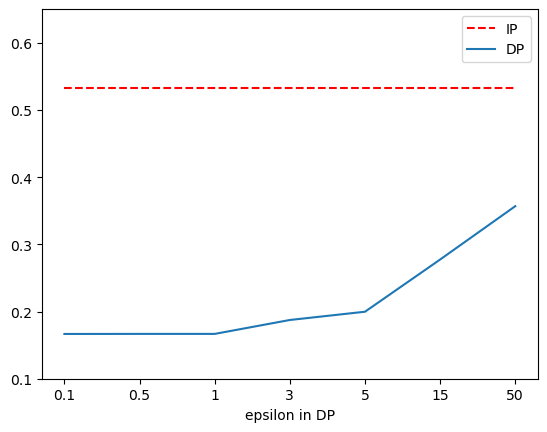

In [6]:
#here onwards plotting the acc_score for epsilon values and ip models acc_score has been calculate for say epsilon 3 ≈(noise_multiplier 0.65 in compute_sgd)
#plt.yticks([0.70, 0.75, 0.80, 0.90,0.95],["0.70","0.75","0.80","0.85","0.90"])
epsilon_list = ['0.1', '0.5', '1', '3', '5', '15', '50']
plt.xticks([0,1,2,3,4,5,6], epsilon_list)
plt.ylim([0.1,0.65])
acc_DP = [ 0.1666, 0.1667, 0.1667, 0.1874, 0.1997, 0.2774, 0.3568]
ipdd_acc=[0.5331]*len(acc_DP)
plt.plot(ipdd_acc, 'r--', label = "IP" )
plt.plot(acc_DP, label="DP")
plt.xlabel("epsilon in DP")
plt.legend()
plt.savefig("Insect_abrupt DPvsOnlineIP.pdf",dpi=300, bbox_inches='tight')